# Setup

## Import Libraries

In [9]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure
import cvxpy as cp

## Load Models

In [10]:
# model = models.efficientnet_b0(weights='DEFAULT').to('cuda')
# model64 = models.mobilenet_v3_small()
# model64.classifier[0] = torch.nn.Linear(576,1280)
# model64.classifier[3] = torch.nn.Linear(1280,1000)
# model64.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [36]:
pt_models = []
model_names = ["mobilenet_v3_small","mobilenet_v3_large","efficientnet_b0","efficientnet_b1"]
for model_name in model_names:
    pt_models.append(getattr(models,model_name)(weights='IMAGENET1K_V1').eval().to('cuda'))

## Load Validation Sets

### Clean Validation Sets

In [11]:
clean_val_loader = load_imagenet(128,1234,False)
clean_val_loader64 = load_imagenet64(128,1234,False)

### Corrupted Validation Sets

In [12]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=5))
    corr_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=5))

In [20]:
# # freeze parameters other than last layer
# for i,c in enumerate(model64.children()):
#     if i != 2:
#         for param in c.parameters():
#             param.requires_grad = False
#         # for param in c[0].parameters():
#         #     param.requires_grad = False
#     # else:
#     #     for param in c.parameters():
#     #         if len(param.shape) != 1:
#     #             param.requires_grad = False
# sum(p.numel() for p in model64.parameters() if p.requires_grad)
from torch.utils.data import Subset
from torch.utils.data.sampler import Sampler
class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

def filter_probs_batch(probs,k):
    topk_probs = torch.topk(probs,k)[0]
    topk_probs /= topk_probs.sum(dim=1).unsqueeze(0).T
    return topk_probs

def filter_probs(probs,k):
    topk_probs = torch.topk(probs,k)[0]
    topk_probs /= topk_probs.sum()
    return topk_probs



acc = 0
opt64 = torch.optim.SGD(model64.parameters(),0.002,0.9)
for i,loader in enumerate(corr_val_loaders64):
    train_split64, val_split64 = torch.utils.data.random_split(loader.dataset, [10000, 50000-10000],torch.Generator().manual_seed(42))
    rand_order = CustomOrder(train_split64)
    train_loader64 = torch.utils.data.DataLoader(train_split64, batch_size=64, sampler=rand_order, pin_memory=True,num_workers=4)
    val_loader64 = torch.utils.data.DataLoader(val_split64, batch_size=128, shuffle=True, pin_memory=True,num_workers=4)
    train_split, val_split = torch.utils.data.random_split(corr_val_loaders[i].dataset, [10000, 50000-10000],torch.Generator().manual_seed(42))
    train_loader = torch.utils.data.DataLoader(train_split, batch_size=64, sampler=rand_order, pin_memory=True,num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_split, batch_size=128, shuffle=True, pin_memory=True,num_workers=4)
    print("****************************", corruptions[i],"****************************")
    model64_c = copy.deepcopy(model64)
    opt64 = torch.optim.SGD(model64_c.parameters(),0.001,0.9)
    for j in range(4):
        dl = iter(train_loader)
        dl64 = iter(train_loader64)
        img,target = next(dl)
        img,target = img.to('cuda'),target.to('cuda')
        img64,target64 = next(dl64)
        img64,target64 = img64.to('cuda'),target64.to('cuda')

        with torch.no_grad():
            out = model(img)
        out64 = model64_c(img64)
        pred = out.argmax(dim=1)
        pred64 = out64.argmax(dim=1)
        T = 5
        alpha = 0.9
        loss = nn.KLDivLoss()(F.log_softmax(out64/T, dim=1),
                                F.softmax(out/T, dim=1))* (alpha * T * T) + \
                            F.cross_entropy(out64, torch.tensor(pred).to('cuda'))# * (1. - alpha)
        loss.backward()
        opt64.step()
        opt64.zero_grad()
        # train(model64,train_loader,val_loader,'cuda',0.002,5)
        a = validate(model64_c,val_loader64,'cuda')[0]
        print(a)
    acc += a
print(acc/15)

**************************** gaussian_noise ****************************


/tmp/ipykernel_579543/1824725321.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.cross_entropy(out64, torch.tensor(pred).to('cuda'))# * (1. - alpha)
100%|██████████| 313/313 [00:02<00:00, 104.62it/s]

0.250425



100%|██████████| 313/313 [00:02<00:00, 106.63it/s]

0.2893



100%|██████████| 313/313 [00:02<00:00, 107.35it/s]

0.308275



100%|██████████| 313/313 [00:02<00:00, 107.18it/s]

0.309325
**************************** impulse_noise ****************************



100%|██████████| 313/313 [00:02<00:00, 104.71it/s]

0.2567



100%|██████████| 313/313 [00:02<00:00, 106.41it/s]

0.27725



100%|██████████| 313/313 [00:02<00:00, 106.80it/s]

0.27745



100%|██████████| 313/313 [00:02<00:00, 105.71it/s]

0.26835
**************************** shot_noise ****************************



100%|██████████| 313/313 [00:02<00:00, 105.58it/s]

0.2433



100%|██████████| 313/313 [00:02<00:00, 104.72it/s]

0.276125



100%|██████████| 313/313 [00:02<00:00, 105.53it/s]

0.2915



100%|██████████| 313/313 [00:02<00:00, 104.74it/s]

0.2915
**************************** defocus_blur ****************************



100%|██████████| 313/313 [00:02<00:00, 109.60it/s]

0.32975



100%|██████████| 313/313 [00:02<00:00, 107.82it/s]

0.354525



100%|██████████| 313/313 [00:02<00:00, 108.31it/s]

0.35335



100%|██████████| 313/313 [00:02<00:00, 109.84it/s]

0.334325
**************************** glass_blur ****************************



100%|██████████| 313/313 [00:02<00:00, 105.92it/s]

0.134875



100%|██████████| 313/313 [00:02<00:00, 106.60it/s]

0.185675



100%|██████████| 313/313 [00:02<00:00, 106.55it/s]

0.211325



100%|██████████| 313/313 [00:02<00:00, 107.05it/s]

0.2312
**************************** motion_blur ****************************



100%|██████████| 313/313 [00:02<00:00, 107.37it/s]

0.356575



100%|██████████| 313/313 [00:02<00:00, 108.74it/s]

0.37045



100%|██████████| 313/313 [00:02<00:00, 108.57it/s]


0.37135


100%|██████████| 313/313 [00:02<00:00, 107.42it/s]

0.364975
**************************** zoom_blur ****************************



100%|██████████| 313/313 [00:02<00:00, 109.06it/s]

0.302425



100%|██████████| 313/313 [00:02<00:00, 107.74it/s]

0.319875



100%|██████████| 313/313 [00:02<00:00, 108.26it/s]

0.319775



100%|██████████| 313/313 [00:02<00:00, 109.18it/s]

0.31925
**************************** snow ****************************



100%|██████████| 313/313 [00:02<00:00, 106.72it/s]

0.2833



100%|██████████| 313/313 [00:02<00:00, 106.47it/s]

0.29885



100%|██████████| 313/313 [00:02<00:00, 107.10it/s]

0.3072



100%|██████████| 313/313 [00:02<00:00, 105.71it/s]

0.30635
**************************** frost ****************************



100%|██████████| 313/313 [00:02<00:00, 107.58it/s]

0.294725



100%|██████████| 313/313 [00:02<00:00, 107.05it/s]

0.3022



100%|██████████| 313/313 [00:02<00:00, 105.87it/s]

0.29905



100%|██████████| 313/313 [00:02<00:00, 108.26it/s]

0.288975
**************************** fog ****************************



100%|██████████| 313/313 [00:02<00:00, 107.18it/s]

0.3678



100%|██████████| 313/313 [00:02<00:00, 108.23it/s]

0.37115



100%|██████████| 313/313 [00:02<00:00, 108.09it/s]

0.36755



100%|██████████| 313/313 [00:02<00:00, 109.06it/s]

0.356475
**************************** brightness ****************************



100%|██████████| 313/313 [00:02<00:00, 106.15it/s]

0.401275



100%|██████████| 313/313 [00:02<00:00, 105.88it/s]

0.4046



100%|██████████| 313/313 [00:02<00:00, 106.26it/s]

0.4024



100%|██████████| 313/313 [00:02<00:00, 105.34it/s]

0.3955
**************************** contrast ****************************



100%|██████████| 313/313 [00:02<00:00, 108.13it/s]

0.278725



100%|██████████| 313/313 [00:02<00:00, 110.68it/s]

0.291075



100%|██████████| 313/313 [00:02<00:00, 109.78it/s]

0.293625



100%|██████████| 313/313 [00:02<00:00, 109.72it/s]

0.289625
**************************** elastic_transform ****************************



100%|██████████| 313/313 [00:02<00:00, 108.57it/s]

0.345875



100%|██████████| 313/313 [00:02<00:00, 107.62it/s]

0.3444



100%|██████████| 313/313 [00:02<00:00, 108.12it/s]

0.33585



100%|██████████| 313/313 [00:02<00:00, 107.87it/s]

0.32425
**************************** jpeg_compression ****************************



100%|██████████| 313/313 [00:02<00:00, 108.67it/s]

0.3876



100%|██████████| 313/313 [00:02<00:00, 108.04it/s]

0.38595



100%|██████████| 313/313 [00:02<00:00, 109.04it/s]

0.377



100%|██████████| 313/313 [00:02<00:00, 108.27it/s]

0.3607
**************************** pixelate ****************************



100%|██████████| 313/313 [00:02<00:00, 106.13it/s]

0.362575



100%|██████████| 313/313 [00:02<00:00, 107.96it/s]

0.3773



100%|██████████| 313/313 [00:02<00:00, 107.47it/s]

0.3791



100%|██████████| 313/313 [00:02<00:00, 106.16it/s]

0.3719
0.3208466666666666


# Baseline Accuracies

## test clean validation sets

In [33]:
validate(pt_models[5],clean_val_loader,'cuda')

100%|██████████| 391/391 [04:12<00:00,  1.55it/s]


(0.7854, 0.9210067334992197, 0.9437)

In [98]:
acc_clean = validate(model,clean_val_loader,'cuda')
acc64_clean = validate(model64,clean_val_loader64,'cuda')

100%|██████████| 391/391 [00:17<00:00, 22.39it/s]


## test corrupted validation sets

In [96]:
acc_corr = []
acc_corr64 = []

for i,corr_set in enumerate(corr_val_loaders):
    acc_corr.append(validate(model,corr_val_loaders[i],'cuda'))
    acc_corr64.append(validate(model64,corr_val_loaders64[i],'cuda'))

100%|██████████| 391/391 [00:04<00:00, 82.62it/s]


## save results to csv

In [103]:
import pandas as pd
df = pd.DataFrame(columns=corruptions)
df.loc[0] = [ac[0] for ac in acc_corr]
df.loc[1] = [ac[0] for ac in acc_corr64]
df.insert(0, "Model", ['224x224', '64x64'])
df.insert(1,'Clean Acc.',[acc_clean,acc64_clean])
avg_top1 = 0
avg_top5 = 0
avg_top1_64 = 0
avg_top5_64 = 0
for i,a in enumerate(acc_corr):
    avg_top1 += acc_corr[i][0]
    avg_top5 += acc_corr[i][2]
    avg_top1_64 += acc_corr64[i][0]
    avg_top5_64 += acc_corr64[i][2]
df.insert(2,'Avg Corr. Acc.',[(avg_top1/len(acc_corr),avg_top5/len(acc_corr)),(avg_top1_64/len(acc_corr64),avg_top5_64/len(acc_corr64))])
df.to_csv("accuracy results_latest1.csv")

# Get confidence Scores

## clean confidence scores

### function to get confidence bins and distribution

In [33]:
# pass in validation set and model
def get_conf_cal(data_loader, model):
    # store the confidence and prediction result for each sample
    confidences = torch.zeros(len(data_loader.dataset))
    accuracies = torch.zeros(len(data_loader.dataset))

    # get the confidence and predictions result for each sample
    idx = 0
    with torch.no_grad():
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            # save the next batch of results based on start and end idxs
            start = idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            confidences[start:end] = conf
            accuracies[start:end] = acc
            idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/len(data_loader.dataset)

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1

    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

get the confidence scores for both 224 and 64

In [34]:
accs_cal, confs_cal, confs_hist, total_avg_conf, total_acc = get_conf_cal(clean_val_loader,model)
accs64_cal, confs64_cal, confs_hist64, total_avg_conf64, total_acc64 = get_conf_cal(clean_val_loader64,model64)

100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


conf hist for 224

(-2.5, 47.5)

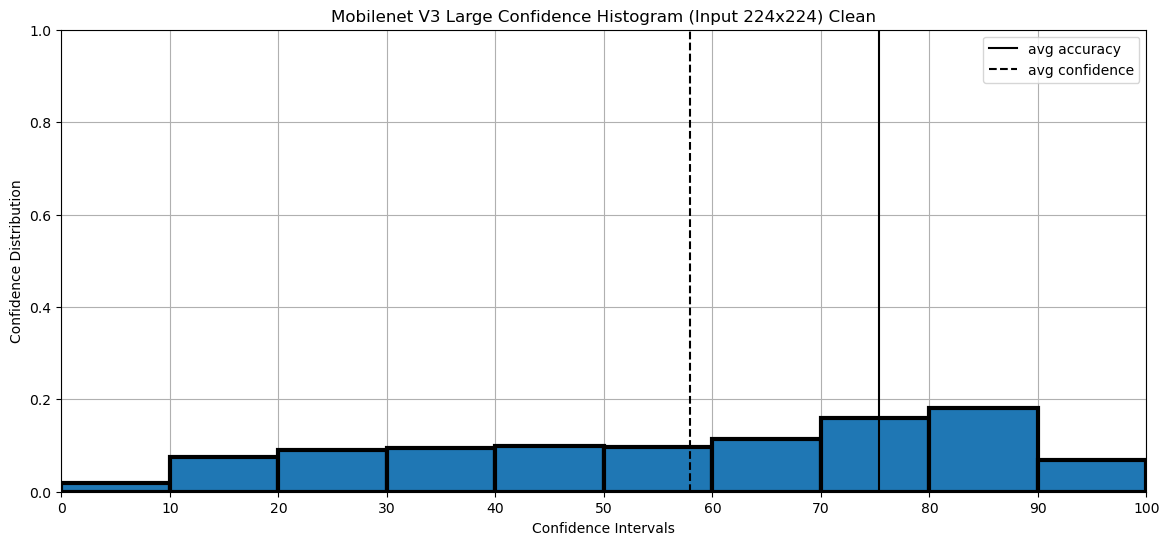

In [35]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 224

[tensor(0.0550), tensor(0.1247), tensor(0.1759), tensor(0.2159), tensor(0.2207), tensor(0.2373), tensor(0.2229), tensor(0.1905), tensor(0.1280), tensor(0.0457)]
[tensor(0.0769), tensor(0.1528), tensor(0.2508), tensor(0.3508), tensor(0.4500), tensor(0.5506), tensor(0.6525), tensor(0.7538), tensor(0.8466), tensor(0.9344)]


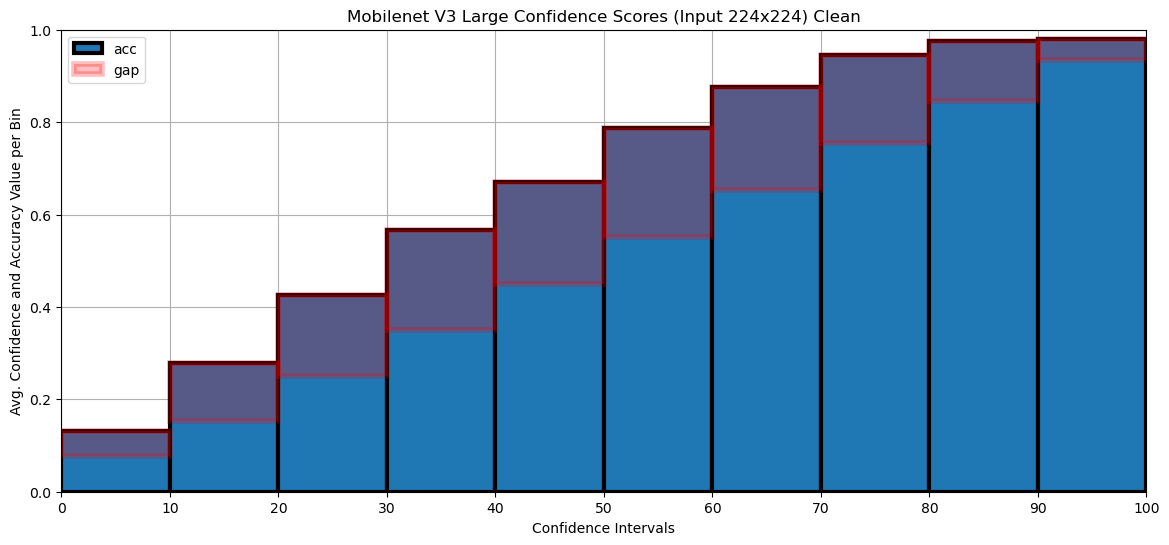

In [36]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs_cal):
    if c > accs_cal[i]:
        bot.append(accs_cal[i])
        top.append(c-accs_cal[i])
    else:
        bot.append(c)
        top.append(accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [37]:
print("ECE:",sum([abs(accs_cal[i] - confs_cal[i])*confs_hist[i] for i in range(len(confs_cal))]))

ECE: tensor(0.1738)


conf hist for 64

(-2.5, 47.5)

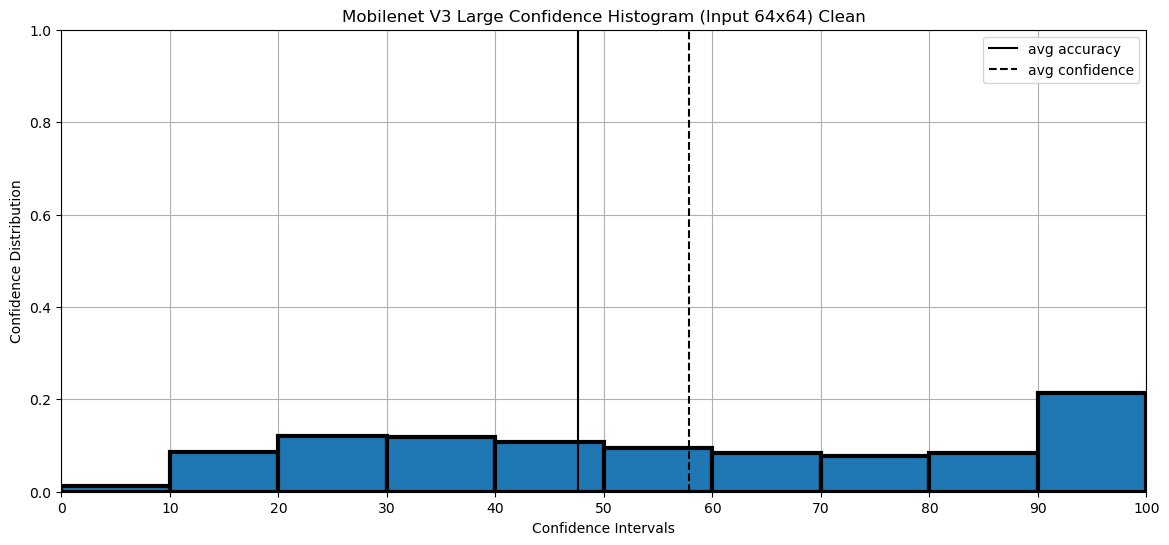

In [38]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc64*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 64

[tensor(0.0273), tensor(0.0557), tensor(0.0825), tensor(0.1085), tensor(0.1101), tensor(0.1366), tensor(0.1562), tensor(0.1568), tensor(0.1375), tensor(0.0586)]
[tensor(0.0548), tensor(0.1010), tensor(0.1688), tensor(0.2406), tensor(0.3385), tensor(0.4113), tensor(0.4934), tensor(0.5934), tensor(0.7146), tensor(0.9113)]


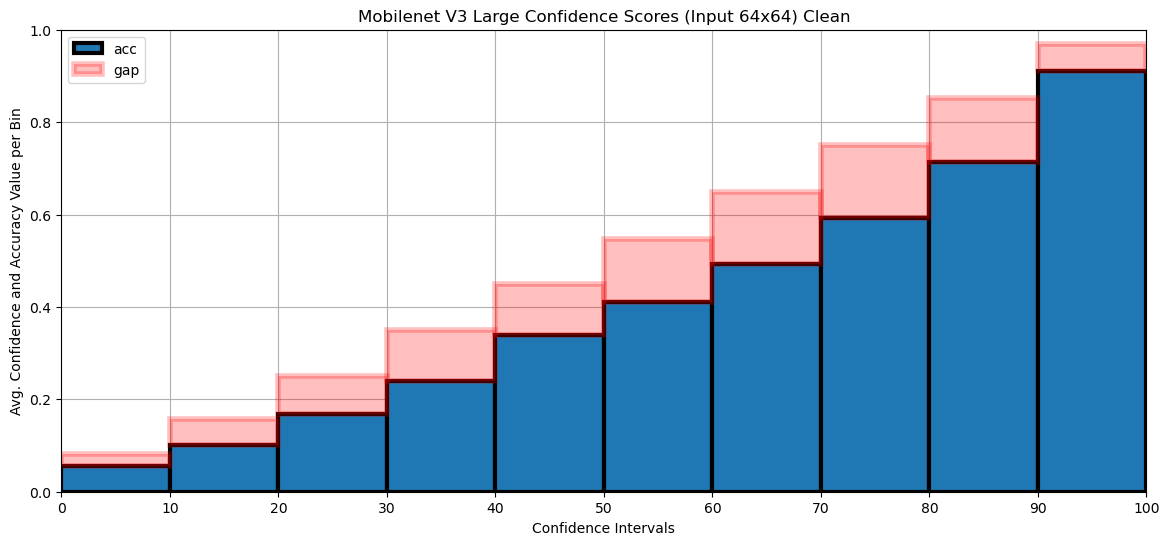

In [39]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs64_cal):
    if c > accs64_cal[i]:
        bot.append(accs64_cal[i])
        top.append(c-accs64_cal[i])
    else:
        bot.append(c)
        top.append(accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [40]:
print("ECE:",sum([abs(accs64_cal[i] - confs64_cal[i])*confs_hist64[i] for i in range(len(confs64_cal))]))

ECE: tensor(0.1022)


## Corrupted Confidence Scores

### function to get scores for all corruptions

In [41]:
# pass in validation sets and model
def get_conf_cal_corr(data_loaders, model):
    # store confidences and prediction results over all validation sets
    confidences = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    accuracies = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    print(len(confidences))

    # iterate over all validation sets
    with torch.no_grad():
        for dl_idx, data_loader in enumerate(data_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        print(in_bin,"/",len(in_bin))

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/(len(data_loader.dataset)*len(data_loaders))

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
        
    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

In [42]:
corr_accs_cal, corr_confs_cal, corr_confs_hist, corr_total_avg_conf, corr_total_acc  = get_conf_cal_corr(corr_val_loaders,model)
corr_accs64_cal, corr_confs64_cal,corr_confs_hist64, corr_total_avg_conf64, corr_total_acc64  = get_conf_cal_corr(corr_val_loaders64,model64)

750000
gaussian_noise


100%|██████████| 391/391 [00:25<00:00, 15.58it/s]


impulse_noise


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


shot_noise


100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


defocus_blur


100%|██████████| 391/391 [00:22<00:00, 17.55it/s]


glass_blur


100%|██████████| 391/391 [00:22<00:00, 17.21it/s]


motion_blur


100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


zoom_blur


100%|██████████| 391/391 [00:22<00:00, 17.40it/s]


snow


100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


frost


100%|██████████| 391/391 [00:23<00:00, 16.71it/s]


fog


100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


brightness


100%|██████████| 391/391 [00:23<00:00, 16.86it/s]


contrast


100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


elastic_transform


100%|██████████| 391/391 [00:22<00:00, 17.12it/s]


jpeg_compression


100%|██████████| 391/391 [00:21<00:00, 18.25it/s]


pixelate


100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


tensor([False, False, False,  ..., False,  True, False]) / 750000
tensor([ True,  True, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False,  True]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
750000
gaussian_noise


100%|██████████| 391/391 [00:04<00:00, 84.87it/s]


impulse_noise


100%|██████████| 391/391 [00:04<00:00, 85.48it/s]


shot_noise


100%|██████████| 391/391 [00:04<00:00, 85.18it/s]


defocus_blur


100%|██████████| 391/391 [00:04<00:00, 87.68it/s]


glass_blur


100%|██████████| 391/391 [00:04<00:00, 85.72it/s]


motion_blur


100%|██████████| 391/391 [00:04<00:00, 87.34it/s]


zoom_blur


100%|██████████| 391/391 [00:04<00:00, 88.48it/s]


snow


100%|██████████| 391/391 [00:04<00:00, 85.96it/s]


frost


100%|██████████| 391/391 [00:04<00:00, 85.68it/s]


fog


100%|██████████| 391/391 [00:04<00:00, 87.43it/s]


brightness


100%|██████████| 391/391 [00:04<00:00, 84.69it/s]


contrast


100%|██████████| 391/391 [00:04<00:00, 86.09it/s]


elastic_transform


100%|██████████| 391/391 [00:04<00:00, 87.31it/s]


jpeg_compression


100%|██████████| 391/391 [00:04<00:00, 88.25it/s]


pixelate


100%|██████████| 391/391 [00:04<00:00, 87.86it/s]

tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False, False,  True]) / 750000
tensor([False, False, False,  ...,  True,  True, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000


corr hist for 224

(-2.5, 47.5)

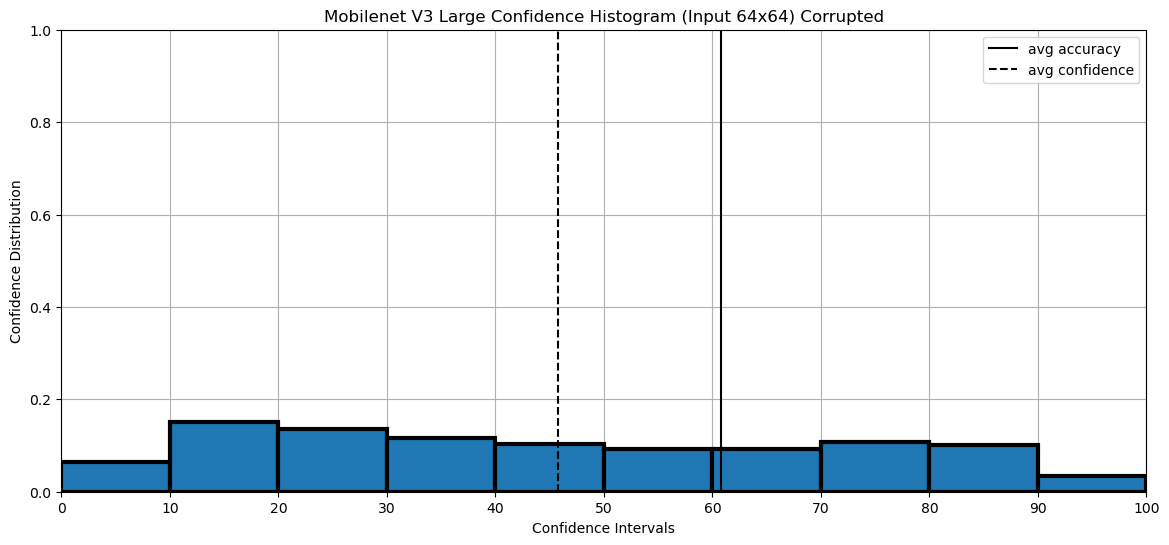

In [43]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 224

[tensor(0.0546), tensor(0.0996), tensor(0.1464), tensor(0.1774), tensor(0.2000), tensor(0.2109), tensor(0.2046), tensor(0.1732), tensor(0.1183), tensor(0.0446)]
[tensor(0.0722), tensor(0.1499), tensor(0.2488), tensor(0.3491), tensor(0.4488), tensor(0.5497), tensor(0.6507), tensor(0.7515), tensor(0.8467), tensor(0.9319)]


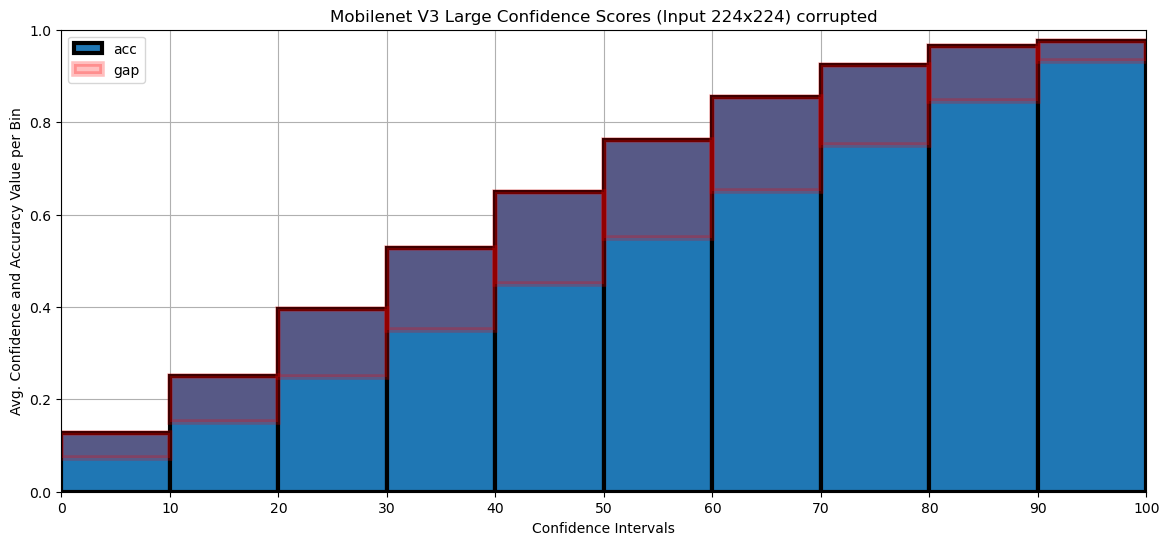

In [44]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs_cal):
    if c > corr_accs_cal[i]:
        bot.append(corr_accs_cal[i])
        top.append(c-corr_accs_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [45]:
print("ECE:",sum([abs(corr_accs_cal[i] - corr_confs_cal[i])*corr_confs_hist[i] for i in range(len(corr_confs_cal))]))

ECE: tensor(0.1505)


corr hist for 64

(-2.5, 47.5)

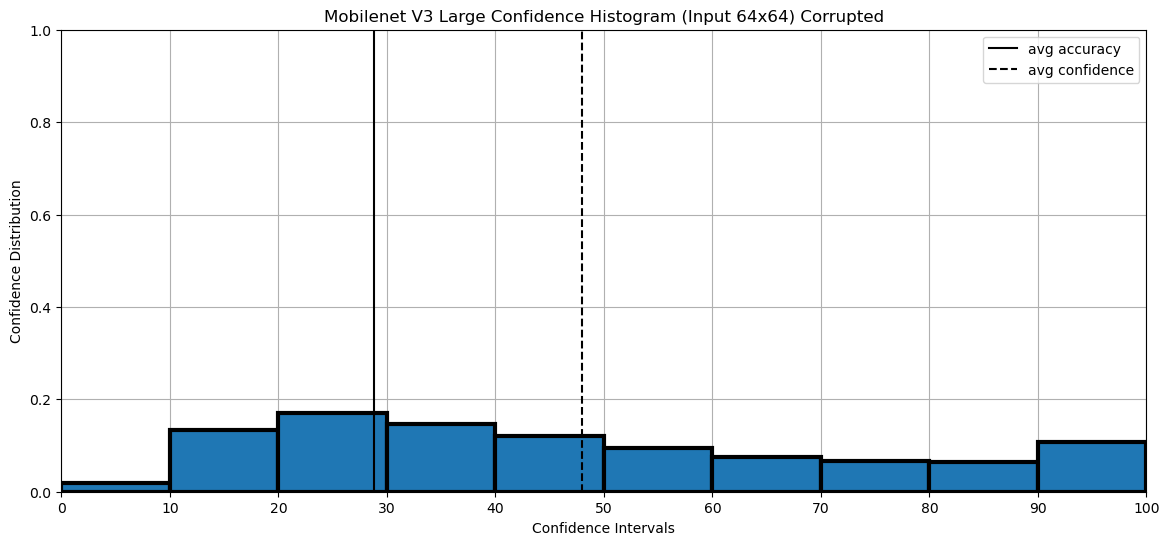

In [46]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc64*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 64

[tensor(0.0448), tensor(0.0865), tensor(0.1365), tensor(0.1841), tensor(0.2254), tensor(0.2608), tensor(0.2953), tensor(0.3096), tensor(0.2904), tensor(0.1407)]
[tensor(0.0373), tensor(0.0695), tensor(0.1131), tensor(0.1643), tensor(0.2229), tensor(0.2869), tensor(0.3533), tensor(0.4393), tensor(0.5598), tensor(0.8228)]


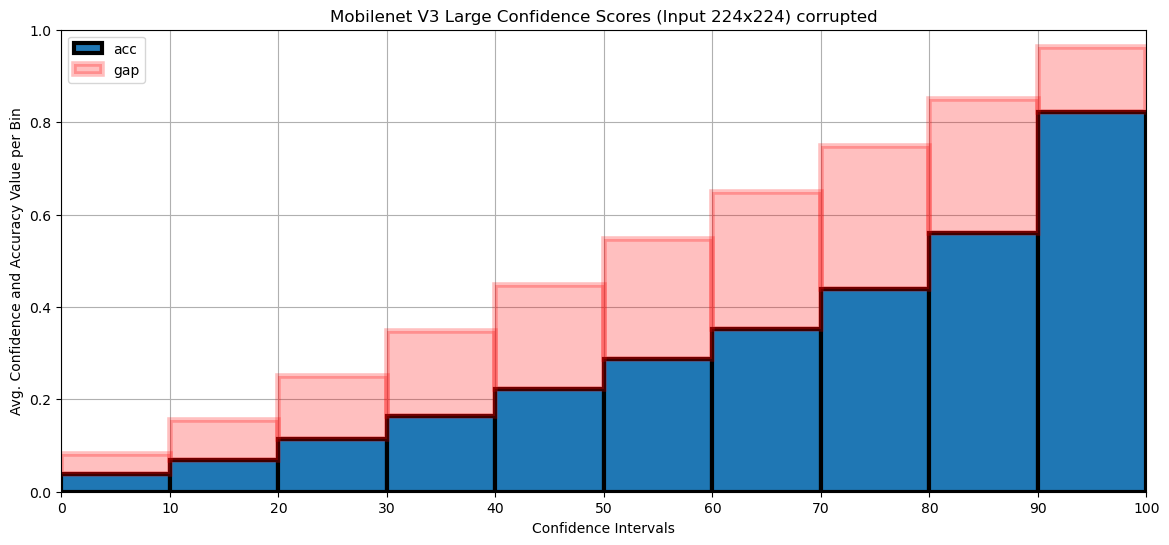

In [47]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs64_cal):
    if c > corr_accs64_cal[i]:
        bot.append(corr_accs64_cal[i])
        top.append(c-corr_accs64_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [48]:
print("ECE:",sum([abs(corr_accs64_cal[i] - corr_confs64_cal[i])*corr_confs_hist64[i] for i in range(len(corr_confs64_cal))]))

ECE: tensor(0.1913)


# Online Accuracies

## Deterministic Baselines

get all the confidences and results for each model on each dataset
* pre-computing then reusing results after is faster
* only works for fixed model
* this gives predictions in non-shuffled order, post-evaluation must be shuffled

In [ ]:
# confidence is highest softmax output
# result is whether a prediction was correct

# all confs and results on clean sets
clean_confidences = torch.zeros(len(clean_val_loader.dataset))
clean_results = torch.zeros(len(clean_val_loader.dataset))
clean_confidences64 = torch.zeros(len(clean_val_loader.dataset))
clean_results64 = torch.zeros(len(clean_val_loader.dataset))

# all confs and results on corrupted sets
corr_confidences = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_confidences64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))

# put all datasets in fixed order
# fixed_order = CustomOrder(clean_val_loader.dataset)
# rand_corr_order = torch.randperm(15)

with torch.no_grad():
    # first get the clean results for 224 and 64
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences[start:end] = conf
        clean_results[start:end] = res
        batch_idx += 1
    torch.save(clean_confidences,"accs/clean_confs224.pt")
    torch.save(clean_results,"accs/clean_results224.pt")
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader64):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader64.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences64[start:end] = conf
        clean_results64[start:end] = res
        batch_idx += 1
    torch.save(clean_confidences64,"accs/clean_confs64.pt")
    torch.save(clean_results64,"accs/clean_results64.pt")
    # get corrupted results
    for dl_idx, data_loader in enumerate(corr_val_loaders):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences[start:end] = conf
            corr_results[start:end] = acc

            idx +=  1
    torch.save(corr_confidences,"accs/corr_confs224.pt")
    torch.save(corr_results,"accs/corr_results224.pt")
    for dl_idx, data_loader in enumerate(corr_val_loaders64):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences64[start:end] = conf
            corr_results64[start:end] = acc

            idx +=  1
    torch.save(corr_confidences64,"accs/corr_confs64.pt")
    torch.save(corr_results64,"accs/corr_results64.pt")

for all models

In [ ]:
# confidence is highest softmax output
# result is whether a prediction was correct

# all confs and results on clean sets
clean_confidences = [torch.zeros(len(clean_val_loader.dataset)) for mn in model_names]
clean_results = [torch.zeros(len(clean_val_loader.dataset)) for mn in model_names]

# all confs and results on corrupted sets
corr_confidences = [torch.zeros(len(clean_val_loader.dataset)*len(corruptions)) for mn in model_names]
corr_results = [torch.zeros(len(clean_val_loader.dataset)*len(corruptions)) for mn in model_names]


with torch.no_grad():
    for mn_i,mn in enumerate(model_names):
        # first get the clean results for 224 and 64
        batch_idx = 0
        for (img_batch, label_batch) in tqdm(clean_val_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
            start = batch_idx*clean_val_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions
            conf, pred = torch.max(F.softmax(pt_models[mn_i](img_batch), dim=1), 1)
            res = pred.eq(label_batch)
            conf,res = conf.to('cpu'),res.to('cpu')

            clean_confidences[mn_i][start:end] = conf
            clean_results[mn_i][start:end] = res
            batch_idx += 1
        torch.save(clean_confidences[mn_i],"accs/clean_confs224_"+mn+".pt")
        torch.save(clean_results[mn_i],"accs/clean_results224"+mn+".pt")
        batch_idx = 0
        
        # get corrupted results
        for dl_idx, data_loader in enumerate(corr_val_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(pt_models[mn_i](img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                corr_confidences[mn_i][start:end] = conf
                corr_results[mn_i][start:end] = acc

                idx +=  1
        torch.save(corr_confidences[mn_i],"accs/corr_confs224"+mn+".pt")
        torch.save(corr_results[mn_i],"accs/corr_results224"+mn+".pt")

In [47]:

ops = []
accs = []
for c in range(15):
    g_conf64 = corr_confidences64[50000*c:50000*c+50000]
    g_res64 = corr_results64[50000*c:50000*c+50000]
    g_res = corr_results[50000*c:50000*c+50000]
    policies = np.linspace(0,1,21)
    idxs = [(g_conf64<p).nonzero() for p in policies]
    idxs64 = [np.setdiff1d(np.arange(0,50000),idxs[i]) for i in range(len(policies))]

    num_big = torch.tensor([len(g_res[idxs[i]]) for i in range(len(policies))])
    num_correct = torch.tensor([sum(g_res[idxs[i]]) for i in range(len(policies))]) + torch.tensor([sum(g_res64[idxs64[i]]) for i in range(len(policies))])
    num_small = 50000 - num_big
    num_ops = num_big*(234+22)+num_small*(22)
    ops.append(num_ops)
    accs.append(num_correct/50000)
    plt.scatter(num_ops,num_correct/50000,label=corruptions[c])
plt.legend()

load the saved confs and results

In [13]:
# all confs and results on clean sets
clean_confidences = torch.load("accs/clean_confs224.pt")
clean_results = torch.load("accs/clean_results224.pt")
clean_confidences64 = torch.load("accs/clean_confs64.pt")
clean_results64 = torch.load("accs/clean_results64.pt")

# all confs and results on corrupted sets
corr_confidences = torch.load("accs/corr_confs224.pt")
corr_results = torch.load("accs/corr_results224.pt")
corr_confidences64 = torch.load("accs/corr_confs64.pt")
corr_results64 = torch.load("accs/corr_results64.pt")

In [37]:
clean_confidences = [torch.zeros(len(clean_val_loader.dataset)) for mn in model_names]
clean_results = [torch.zeros(len(clean_val_loader.dataset)) for mn in model_names]

# all confs and results on corrupted sets
corr_confidences = [torch.zeros(len(clean_val_loader.dataset)*len(corruptions)) for mn in model_names]
corr_results = [torch.zeros(len(clean_val_loader.dataset)*len(corruptions)) for mn in model_names]

for mn_i,mn in enumerate(model_names):
    clean_confidences[mn_i] = torch.load("accs/clean_confs224_"+mn+".pt")
    clean_results[mn_i] = torch.load("accs/clean_results224"+mn+".pt")
    corr_confidences[mn_i] = torch.load("accs/corr_confs224"+mn+".pt")
    corr_results[mn_i] = torch.load("accs/corr_results224"+mn+".pt")

### setting the ordering

In [14]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

### evaluating strategies for fixed model on clean set

In [21]:
# clean baseline
clean_online_acc = []
clean_online_efficiency = []
clean_online_acc64 = []
clean_online_efficiency64 = []
clean_online_ops = []
clean_online_ops64 = []

policies = np.linspace(0,1,21)
clean_naive_online_acc = [[] for p in range(len(policies))]
clean_naive_efficiency = [[] for p in range(len(policies))]
clean_naive_ops = [[] for p in range(len(policies))]

clean_oracle_acc = []
clean_oracle_efficiency = []
clean_oracle_ops = []
idxs = []

num_imgs = 0

clean_num_correct = 0
clean_num_correct64 = 0
clean_num_naive_correct = [0 for p in range(len(policies))]
clean_num_oracle_correct = 0


clean_naive_num_wrong_decisions = 0
clean_naive_num_choose_small = [0 for p in range(len(policies))]
clean_naive_num_choose_big = [0 for p in range(len(policies))]
clean_oracle_num_choose_small = 0
clean_oracle_num_choose_big = 0

small_right_big_wrong = []
big_right_small_wrong = []

clean_overconfident_locations = []
clean_overconfident_imgs = []
clean_underconfident_locations = []
clean_underconfident_imgs = []

for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the prediction
    out = clean_confidences[sample_idx]
    out64 = clean_confidences64[sample_idx]
    res = clean_results[sample_idx]
    res64 = clean_results64[sample_idx]
    clean_num_correct += res
    clean_num_correct64 += res64
    clean_online_acc.append(clean_num_correct/num_imgs)
    clean_online_acc64.append(clean_num_correct64/num_imgs)
    clean_online_efficiency.append(0)
    clean_online_efficiency64.append(1)
    clean_online_ops.append(234)
    clean_online_ops64.append(22)

    # oracle, if small is right choose small, else choose big
    if res64:
        clean_num_oracle_correct += res64
        clean_oracle_num_choose_small += 1
    else:
        clean_num_oracle_correct += res
        clean_oracle_num_choose_big += 1
    clean_oracle_acc.append(clean_num_oracle_correct/num_imgs) 
    clean_oracle_efficiency.append(clean_oracle_num_choose_small/num_imgs)   
    clean_oracle_ops.append((clean_oracle_num_choose_small*22+clean_oracle_num_choose_big*234)/num_imgs)

    if not res and res64:
        small_right_big_wrong.append(sample_idx)
    if not res64 and res:
        big_right_small_wrong.append(sample_idx)

    # naive strategy, if less than 50% confident, use big model
    for i,p in enumerate(policies):
        if out64.item() < p:
            clean_num_naive_correct[i] += res
            clean_naive_num_choose_big[i] += 1
            # if was underconfident
            if res64:
                clean_naive_num_wrong_decisions += 1
                clean_underconfident_imgs.append(sample_idx)
                clean_underconfident_locations.append(num_imgs)
        else:
            clean_num_naive_correct[i] += res64
            clean_naive_num_choose_small[i] += 1
            # if was overconfident
            if not res64 and res:
                clean_naive_num_wrong_decisions += 1
                clean_overconfident_imgs.append(sample_idx)
                clean_overconfident_locations.append(num_imgs)
    for i,p in enumerate(policies):
        clean_naive_online_acc[i].append(clean_num_naive_correct[i]/num_imgs)
        clean_naive_efficiency[i].append(clean_naive_num_choose_small[i]/num_imgs)
        clean_naive_ops[i].append((clean_naive_num_choose_small[i]*22+clean_naive_num_choose_big[i]*(234+22))/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:16<00:00, 2997.96it/s]


### accuracy

In [18]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

(0.0, 1.1)

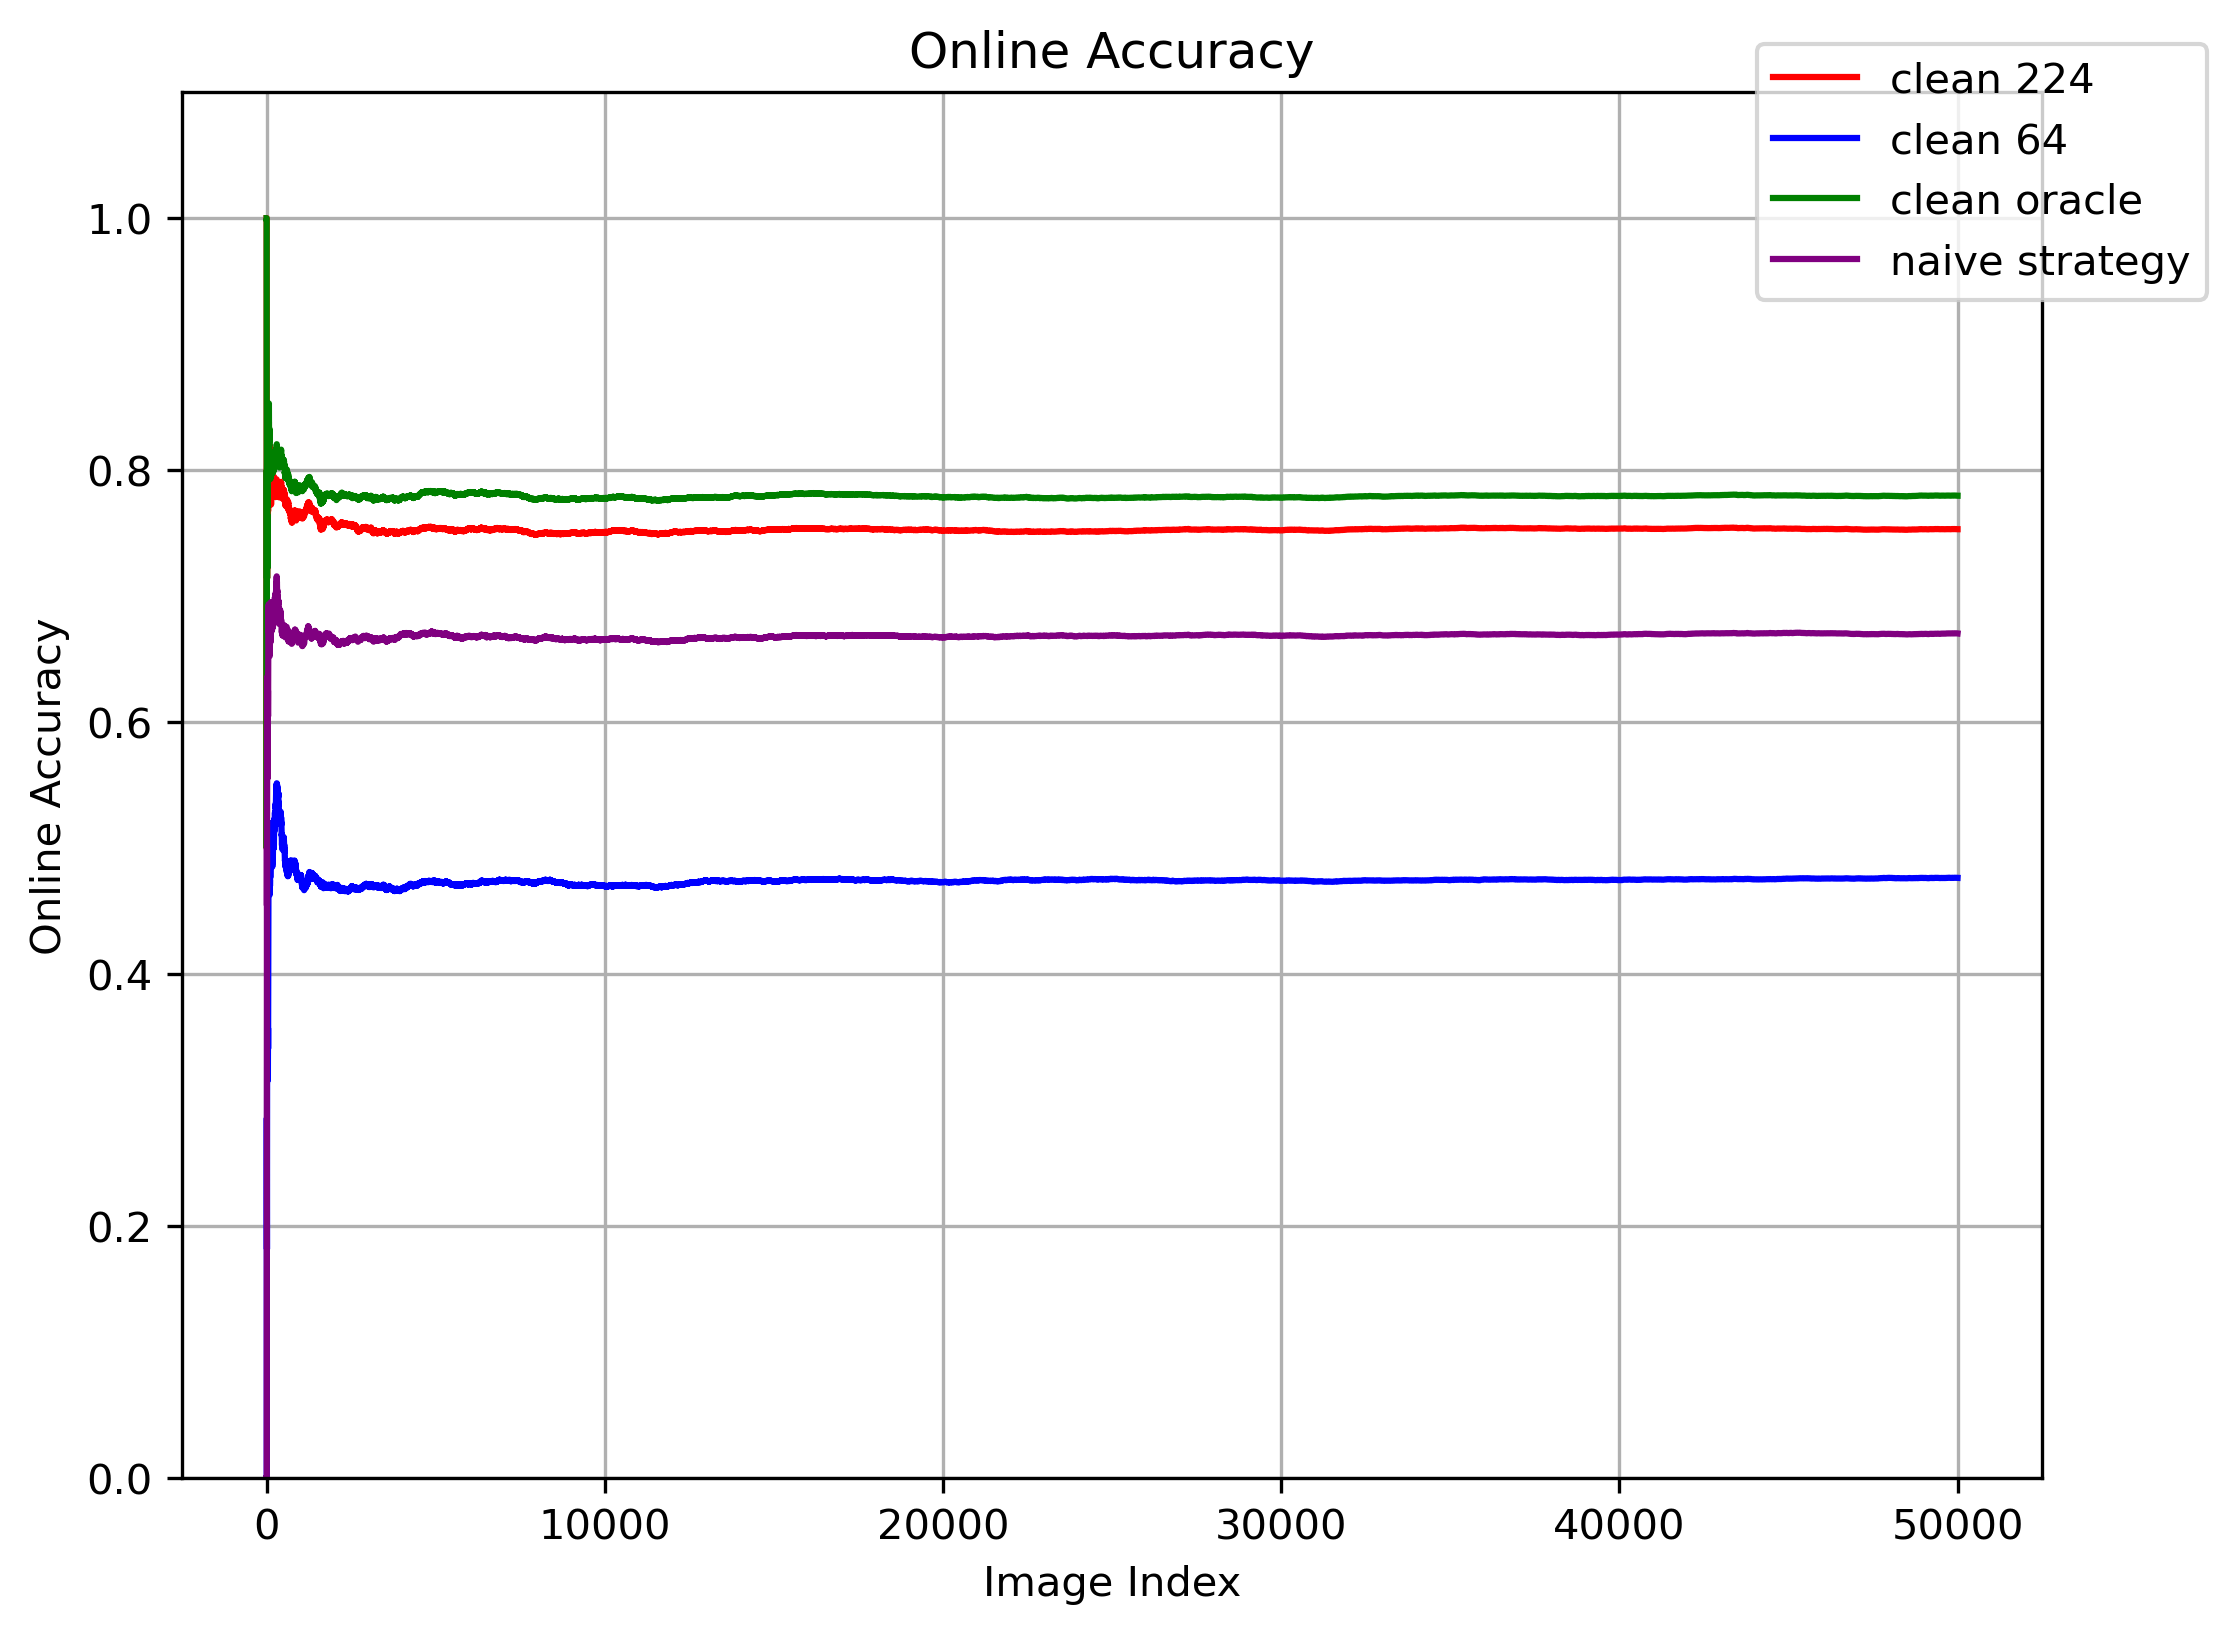

In [19]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_acc,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_online_acc,label='naive strategy',color='purple')

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1.1])
# plt.xlim([0,200])

### efficiency

(-0.1, 1.1)

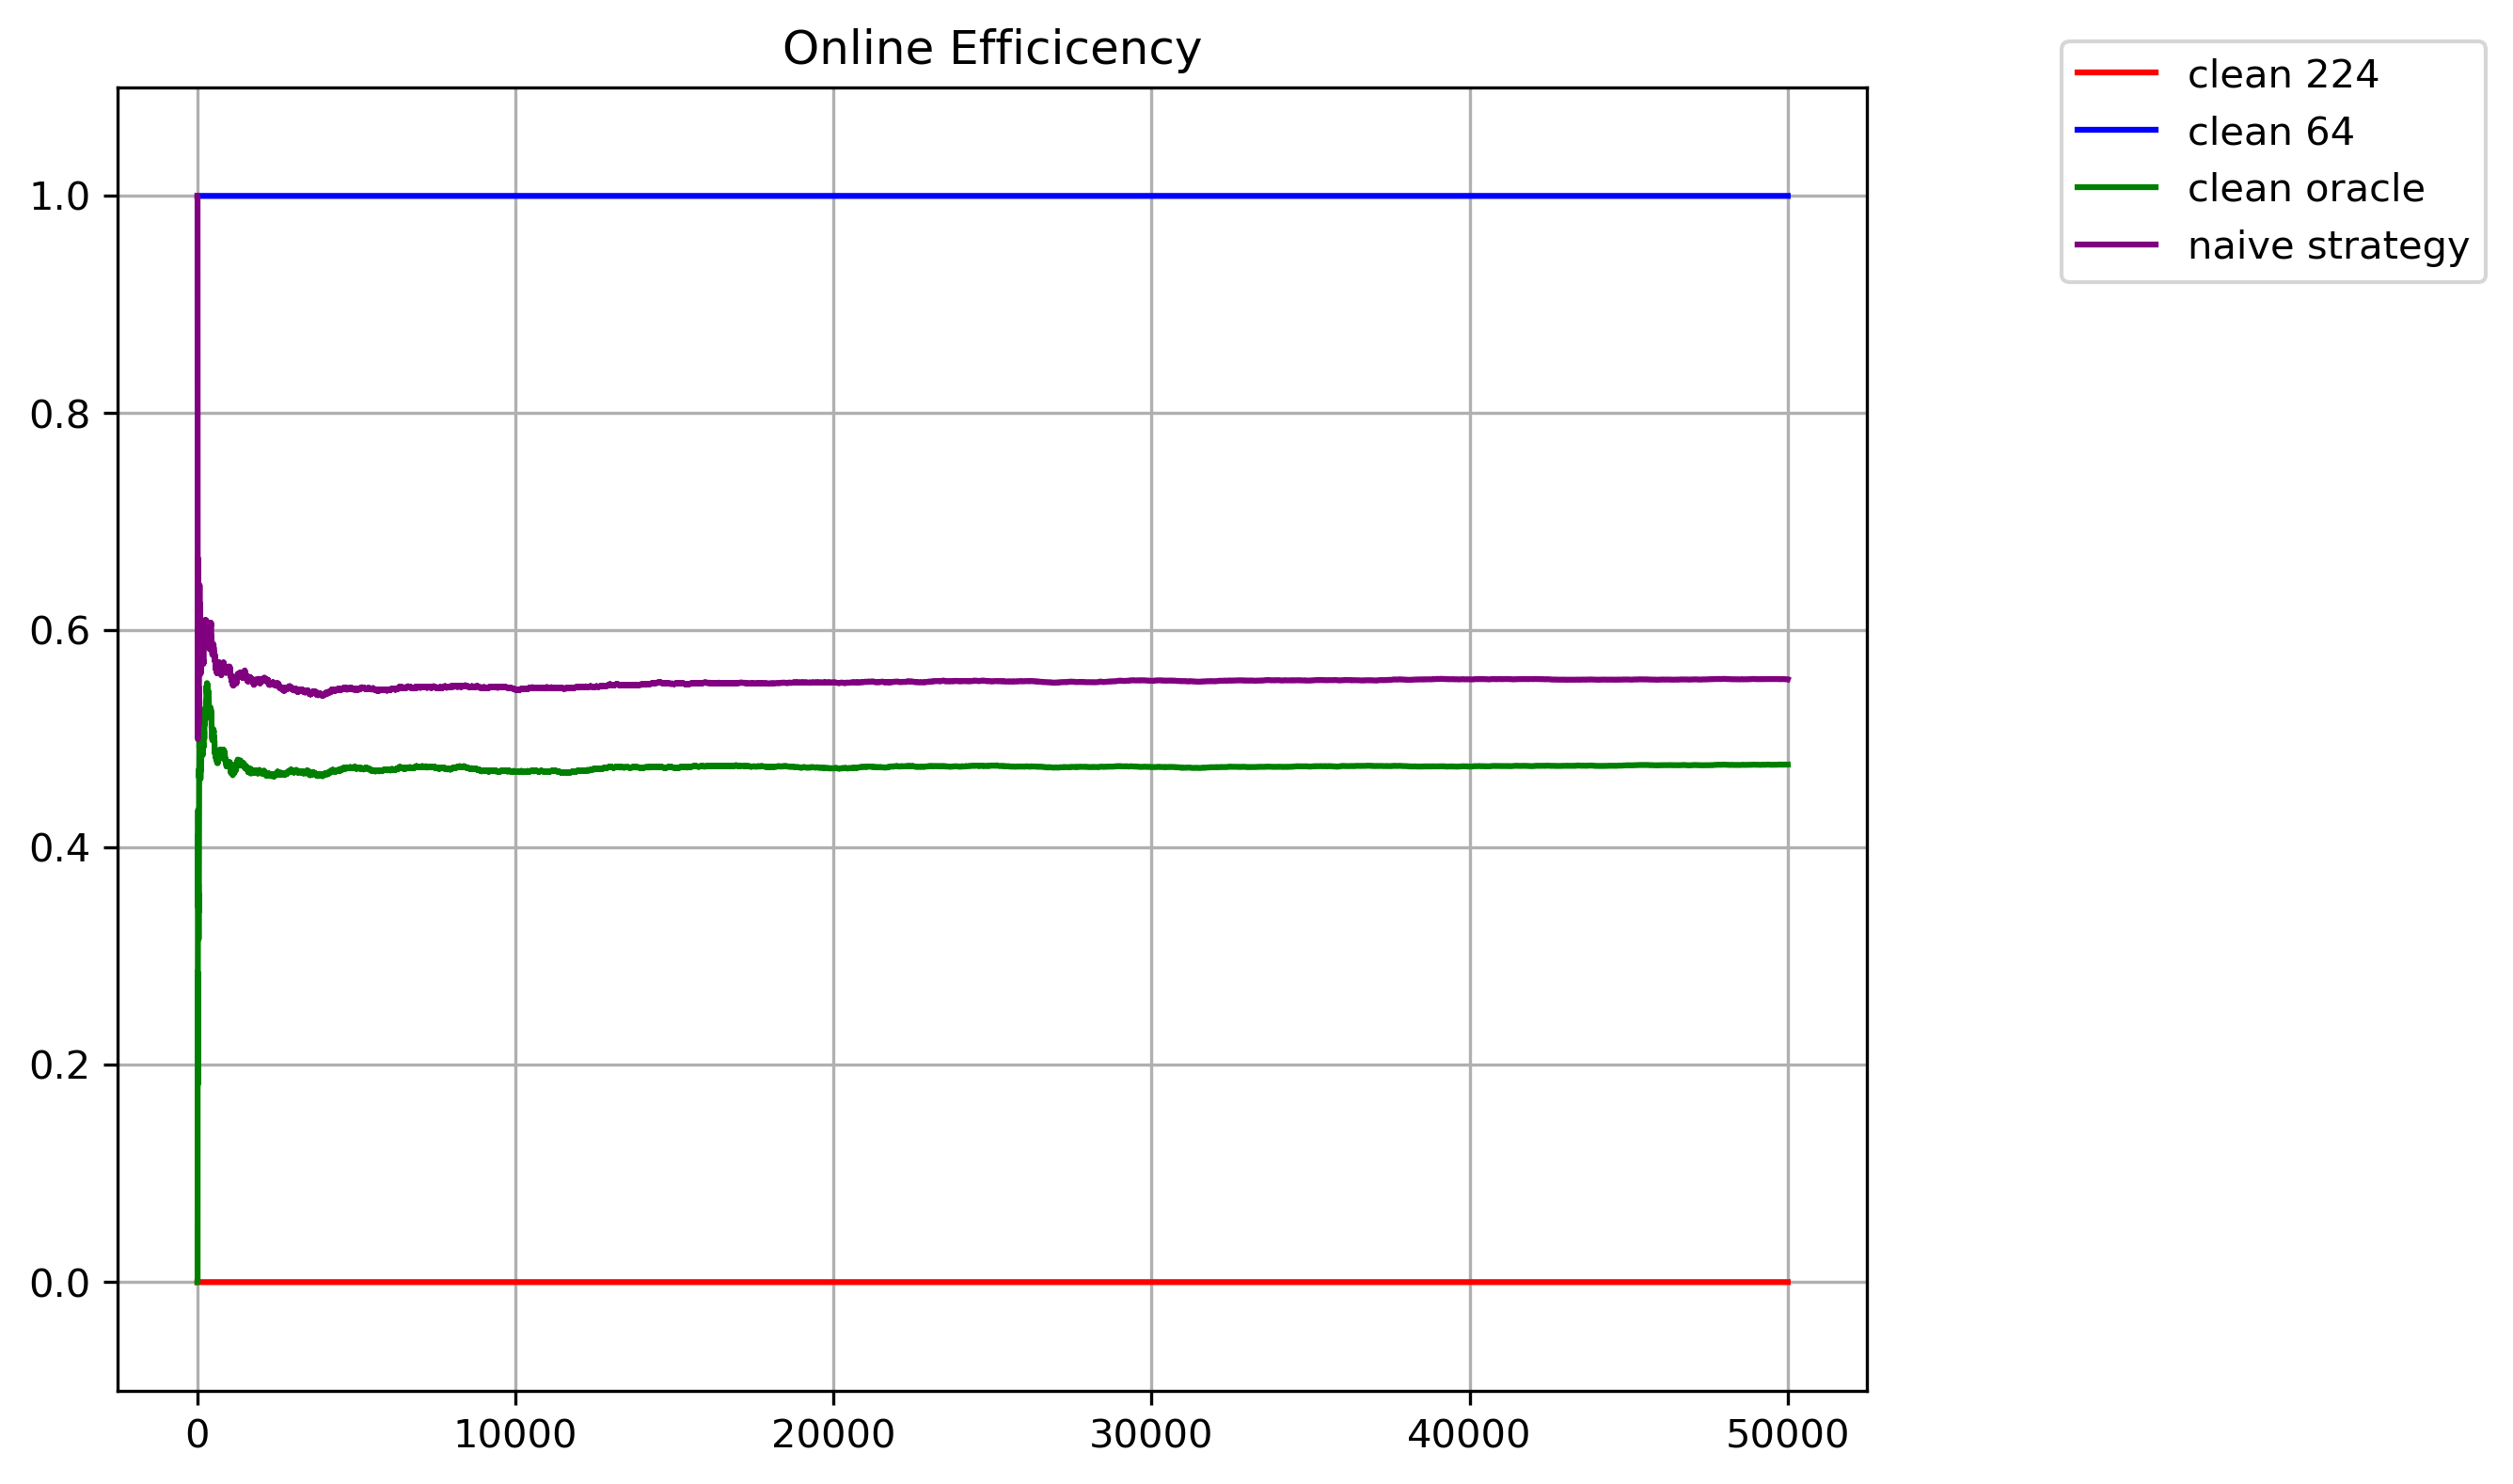

In [20]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_efficiency,label='clean 224',color='red')
ax1.plot(idxs,clean_online_efficiency64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_efficiency,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_efficiency,label='naive strategy',color='purple')
plt.title("Online Efficicency")
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.ylim([-0.1,1.1])
# plt.xlim([0,100])

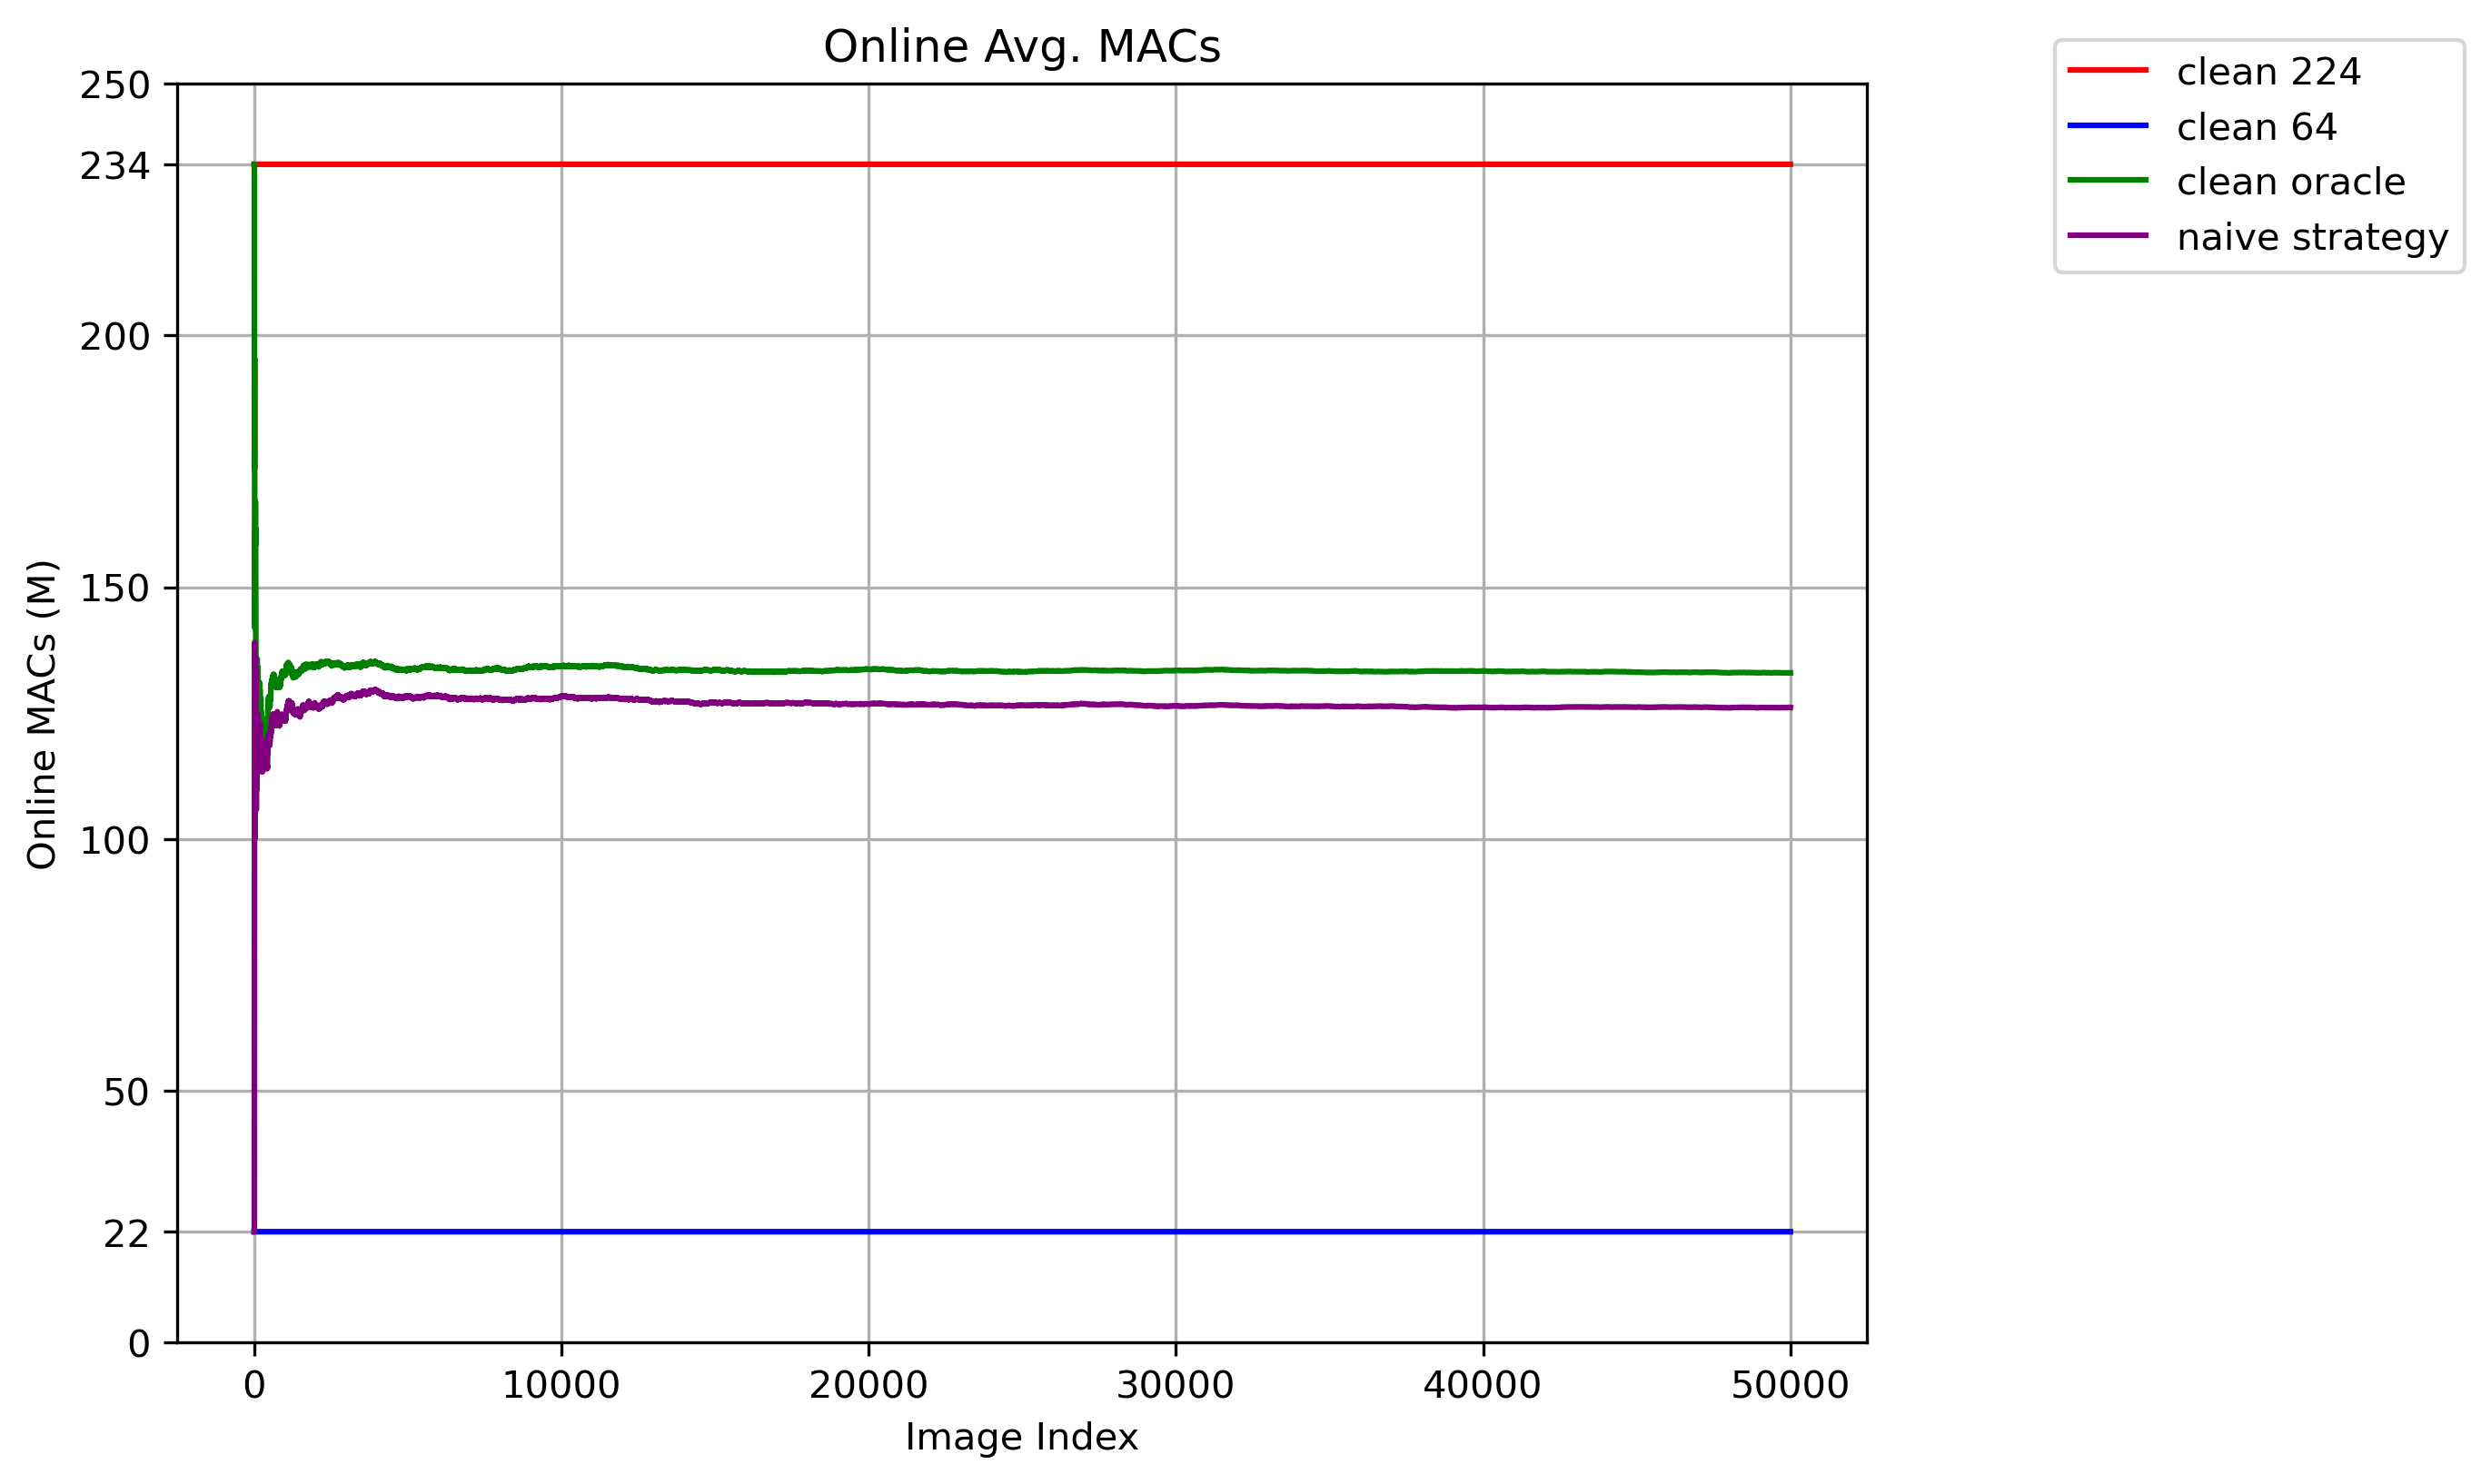

In [21]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_ops,label='clean 224',color='red')
ax1.plot(idxs,clean_online_ops64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_ops,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_ops,label='naive strategy',color='purple')
plt.title("Online Avg. MACs")
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online MACs (M)")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
ax1.set_yticks(list(plt.yticks()[0]) + [22,234])
plt.grid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([672], device='cuda:0') 672  mountain tent


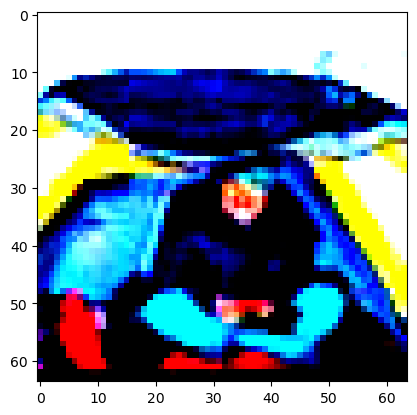

In [80]:
small_correct_big_wrong_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 0)).nonzero()
img,t = clean_val_loader64.dataset[small_right_big_wrong[550]]
plt.imshow(img.permute(1,2,0))
print(model64(img.unsqueeze(0).to('cuda')).argmax(dim=1),t,clean_val_loader.dataset.class_name_map[clean_val_loader.dataset.class_id_list[t]])

### pareto curve for accuracy and efficiency

In [17]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
acc_for_eff = []
big_model_idxs = [torch.zeros(len(clean_results),dtype=torch.bool) for i in range(len(efficiencies))]
small_model_idxs = [torch.zeros(len(clean_results),dtype=torch.bool) for i in range(len(efficiencies))]
for i,eff in enumerate(efficiencies):
    
    curr_acc = 0
    # choose only big
    if eff == 0:
        big_model_idxs[i][:] = True
        continue
    # choose only small
    if eff == 1:
        small_model_idxs[i][:] = True
        continue
    
    
    # for a given efficiency
    eff_thresh = int(eff*len(clean_confidences))
    total_thresh = int(len(clean_confidences))

    # get all idxs where small correct, big wrong
    small_correct_big_wrong_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 0)).nonzero()

    # get all idxs where small and big correct
    small_big_correct_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 1)).nonzero()

    # get all idxs where small wrong, big correct
    small_wrong_big_correct_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 1)).nonzero()

    # get all idxs where big wrong and small wrong
    small_wrong_big_wrong_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 0)).nonzero()
    
    curr_idxs = torch.clone(small_correct_big_wrong_idxs)

    # if above eff threshold (up to eff thresh is small, rest is big)
    if len(curr_idxs) > eff_thresh:
        # remove small until reach efficiency
        curr_idxs = curr_idxs[:eff_thresh]
        small_model_idxs[i][curr_idxs] = True # up until eff thresh

        # add big correct that hven't been taken
        taken = torch.zeros(len(clean_results))
        taken[curr_idxs] = 1
        big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
        curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
        
        # if above total thresh
        if len(curr_idxs) > total_thresh:
            # remove some big to fit the threshold
            curr_idxs = curr_idxs[:total_thresh]
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
        else:
            # add some big wrong and small wrong to fit the threshold
            amnt = total_thresh - len(curr_idxs)
            taken = torch.zeros(len(clean_results))
            taken[curr_idxs] = 1
            big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
    else: 
        # get more by adding predictions which both small and big correct
        curr_idxs = torch.cat((curr_idxs,small_big_correct_idxs))

        # if above efficicency threshold
        if len(curr_idxs) > eff_thresh:
            # remove some small/big correct
            curr_idxs = curr_idxs[:eff_thresh]
            small_model_idxs[i][curr_idxs] = True # up until eff thresh

            # add big correct that hven't been taken
            taken = torch.zeros(len(clean_results))
            taken[curr_idxs] = 1
            big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
            
            # if above total thresh
            if len(curr_idxs) > total_thresh:
                # remove some big to fit the threshold
                curr_idxs = curr_idxs[:total_thresh]
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
            else:
                # add some big wrong that doesn't conflict
                amnt = total_thresh - len(curr_idxs)
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
        else:
            # add small wrong big wrong
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs))

            # if above eff thresh
            if len(curr_idxs) > eff_thresh:
                curr_idxs = curr_idxs[:eff_thresh]
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(clean_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
            else:
                # add small wrong and big correct to reach eff thresh
                amnt = eff_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs[:amnt]))
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(clean_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((clean_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(clean_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((clean_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue


In [18]:
acc_for_eff = []
for i, eff in enumerate(efficiencies):
    assert sum(small_model_idxs[i]).item() + sum(big_model_idxs[i]).item() == len(clean_results) # total num predictions correct
    assert sum(torch.logical_and(small_model_idxs[5],big_model_idxs[5])).item() == 0 # no overlapping idxs
    acc_for_eff.append(((sum(clean_results64[small_model_idxs[i]])+sum(clean_results[big_model_idxs[i]]))/len(clean_results)).item())

acc_eff_plot

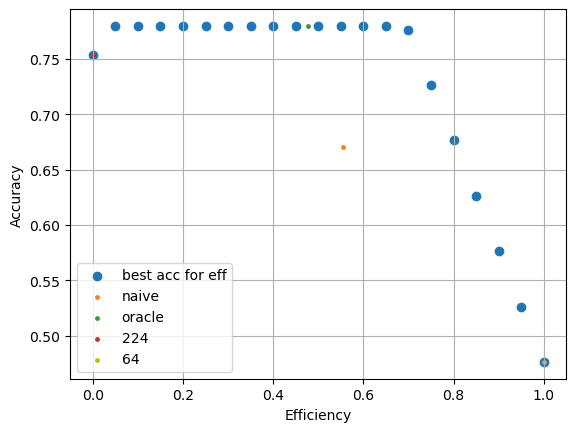

In [19]:
plt.scatter(efficiencies,acc_for_eff,label="best acc for eff")
plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.legend()

In [8]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
accs = []
for e in efficiencies:
    x_sr = clean_results64.numpy()
    x_br = clean_results.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, x_cs.T@ones_vec == int(e*50000)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    accs.append(problem.value)
    # print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", x_cs.value, x_cb.value)

KeyboardInterrupt: 

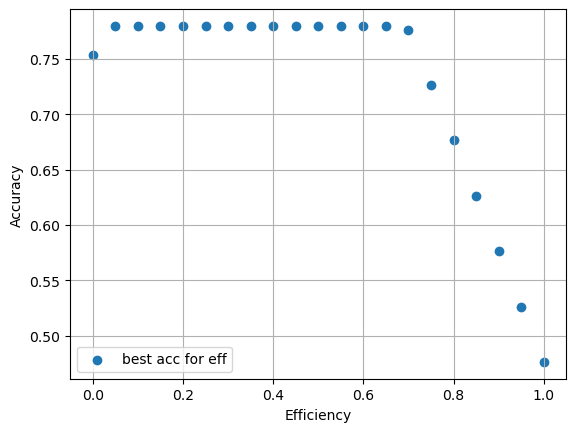

In [8]:
accs = [acc/50000 for acc in accs]
plt.scatter(efficiencies,accs,label="best acc for eff")
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
min_ops = 22*50000
max_ops = (234)*50000
ops = np.linspace(min_ops,max_ops,21)
accs = []
effs = []
for o in ops:
    x_sr = clean_results64.numpy()
    x_br = clean_results.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, 22*x_cs.T@ones_vec + (234)*x_cb.T@ones_vec <= int(o)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve(verbose=True)
    accs.append(problem.value)
    effs.append(sum(x_cs.value)/50000)
    print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", sum(x_cs.value), sum(x_cb.value))

corr_rand_subset = torch.zeros(50000)
corr_rand_subset64 = torch.zeros(50000)
rand_order = torch.randperm(50000)
corr_rand_subset[0:5] = clean_results[rand_order[0:5]]
corr_rand_subset64[0:5] = clean_results64[rand_order[0:5]]
for c_i in range(15):
    start = 5+c_i*3333
    end = start + 3333
    corr_rand_subset[start:end] = corr_results[c_i*50000+rand_order[start:end]]
    corr_rand_subset64[start:end] = corr_results64[c_i*50000+rand_order[start:end]]


corr_accs = []
corr_effs = []
for o in ops:
    x_sr = corr_rand_subset64.numpy()
    x_br = corr_rand_subset.numpy()

    x_cs = cp.Variable(50000, boolean = True)
    x_cb = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_cs + x_cb == ones_vec, 22*x_cs.T@ones_vec + (234)*x_cb.T@ones_vec <= int(o)]
    acc = x_sr.T@x_cs + x_br.T@x_cb

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    corr_accs.append(problem.value)
    corr_effs.append(sum(x_cs.value)/50000)
    print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", x_cs.value, x_cb.value)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 02 04:33:14 PM: Your problem has 100000 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 02 04:33:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 02 04:33:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 02 04:33:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 02 04:33:14 PM: Compiling problem (target solver=SCIPY).
(CVXPY) Feb 02 04:33:14 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr ->

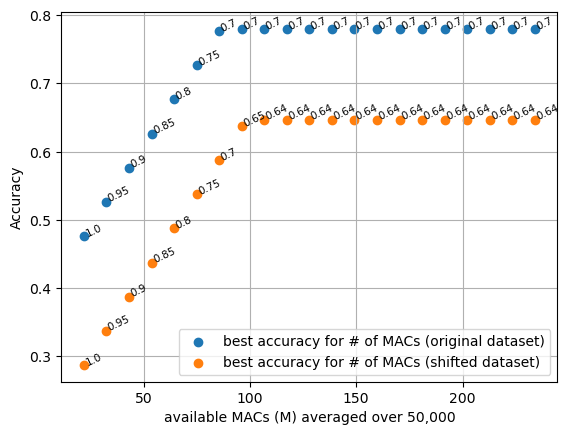

In [23]:
accs2 = [acc/50000 for acc in accs]
corr_accs2 = [acc/50000 for acc in corr_accs]
fig,ax1 = plt.subplots()
ax1.scatter(ops/50000,accs2,label="best accuracy for # of MACs (original dataset)")
ax1.scatter(ops/50000,corr_accs2,label="best accuracy for # of MACs (shifted dataset)")
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
ax1.grid()
ax1.set_xlabel("available MACs (M) averaged over 50,000")
ax1.set_ylabel("Accuracy")
ax1.legend()
effs2 = [round(eff,2) for eff in effs]
corr_effs2 = [round(corr_eff,2) for corr_eff in corr_effs]
for i, txt in enumerate(effs2):
    ax1.annotate(txt, ((ops)[i]/50000, accs2[i]),rotation=25, size=7.5)
    ax1.annotate(corr_effs2[i], ((ops)[i]/50000, corr_accs2[i]),rotation=25, size=7.5)

In [38]:
min_ops = 52.5*50000
max_ops = (610.61)*50000
ops = np.linspace(min_ops,max_ops,21)
accs = []
effs = []
for o in ops:
    x_m0 = clean_results[0].numpy()
    x_m1 = clean_results[1].numpy()
    x_m2 = clean_results[2].numpy()
    x_m3 = clean_results[3].numpy()

    x_c0 = cp.Variable(50000, boolean = True)
    x_c1 = cp.Variable(50000, boolean = True)
    x_c2 = cp.Variable(50000, boolean = True)
    x_c3 = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_c0 + x_c1 + x_c2 + x_c3 == ones_vec, 52.5*x_c0.T@ones_vec + 234.8*x_c1.T@ones_vec + 415.14*x_c2.T@ones_vec + 610.61*x_c3.T@ones_vec <= int(o)]
    acc = x_m0.T@x_c0 + x_m1.T@x_c1 + x_m2@x_c2 + x_m3@x_c3

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve(verbose=True)
    accs.append(problem.value)
    effs.append(sum(x_c0.value)/50000)
    print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", sum(x_cs.value), sum(x_cb.value))

corr_rand_subset0 = torch.zeros(50000)
corr_rand_subset1 = torch.zeros(50000)
corr_rand_subset2 = torch.zeros(50000)
corr_rand_subset3 = torch.zeros(50000)
rand_order = torch.randperm(50000)
corr_rand_subset0[0:5] = clean_results[0][rand_order[0:5]]
corr_rand_subset1[0:5] = clean_results[1][rand_order[0:5]]
corr_rand_subset2[0:5] = clean_results[2][rand_order[0:5]]
corr_rand_subset3[0:5] = clean_results[3][rand_order[0:5]]
for c_i in range(15):
    start = 5+c_i*3333
    end = start + 3333
    corr_rand_subset0[start:end] = corr_results[0][c_i*50000+rand_order[start:end]]
    corr_rand_subset1[start:end] = corr_results[1][c_i*50000+rand_order[start:end]]
    corr_rand_subset2[start:end] = corr_results[2][c_i*50000+rand_order[start:end]]
    corr_rand_subset3[start:end] = corr_results[3][c_i*50000+rand_order[start:end]]


corr_accs = []
corr_effs = []
for o in ops:
    x_m0 = corr_rand_subset0.numpy()
    x_m1 = corr_rand_subset1.numpy()
    x_m2 = corr_rand_subset2.numpy()
    x_m3 = corr_rand_subset3.numpy()

    x_c0 = cp.Variable(50000, boolean = True)
    x_c1 = cp.Variable(50000, boolean = True)
    x_c2 = cp.Variable(50000, boolean = True)
    x_c3 = cp.Variable(50000, boolean = True)
    ones_vec = np.ones(50000)

    constraints = []
    constraints = [x_c0 + x_c1 + x_c2 + x_c3 == ones_vec, 52.5*x_c0.T@ones_vec + 234.8*x_c1.T@ones_vec + 415.14*x_c2.T@ones_vec + 610.61*x_c3.T@ones_vec <= int(o)]
    acc = x_m0.T@x_c0 + x_m1.T@x_c1 + x_m2@x_c2 + x_m3@x_c3

    problem = cp.Problem(cp.Maximize(acc), constraints)

    problem.solve()
    corr_accs.append(problem.value)
    corr_effs.append(sum(x_c0.value)/50000)
    print("status:", problem.status)
    # print("optimal value", problem.value)
    # print("optimal var", x_cs.value, x_cb.value)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 06 01:36:58 PM: Your problem has 200000 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 06 01:36:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 01:36:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 01:36:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06 01:36:58 PM: Compiling problem (target solver=SCIPY).
(CVXPY) Feb 06 01:36:58 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr ->

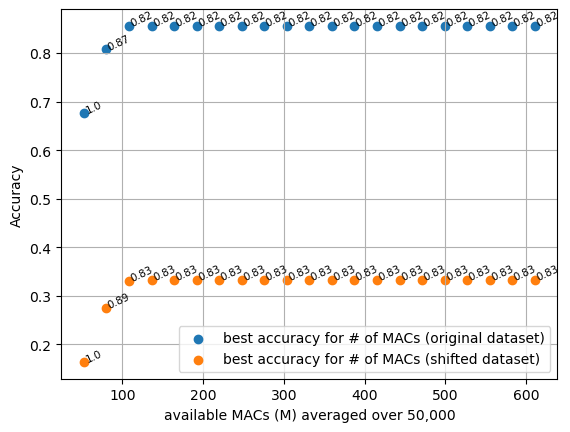

In [10]:
accs2 = [acc/50000 for acc in accs]
corr_accs2 = [acc/50000 for acc in corr_accs]
fig,ax1 = plt.subplots()
ax1.scatter(ops/50000,accs2,label="best accuracy for # of MACs (original dataset)")
ax1.scatter(ops/50000,corr_accs2,label="best accuracy for # of MACs (shifted dataset)")
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
ax1.grid()
ax1.set_xlabel("available MACs (M) averaged over 50,000")
ax1.set_ylabel("Accuracy")
ax1.legend()
effs2 = [round(eff,2) for eff in effs]
corr_effs2 = [round(corr_eff,2) for corr_eff in corr_effs]
for i, txt in enumerate(effs2):
    ax1.annotate(txt, ((ops)[i]/50000, accs2[i]),rotation=25, size=7.5)
    ax1.annotate(corr_effs2[i], ((ops)[i]/50000, corr_accs2[i]),rotation=25, size=7.5)

In [158]:
all_confs = torch.vstack((corr_confidences[0],corr_confidences[1],corr_confidences[2],corr_confidences[3]))
all_results = torch.vstack((corr_results[0],corr_results[1],corr_results[2],corr_results[3]))
ms = all_confs.argmax(dim=0)
correct = 0
for i in range(750000):
    correct += all_results[ms[i],i]

In [163]:
print((52.5*torch.sum(ms==0) + 234.8*torch.sum(ms==1) + 415.14*torch.sum(ms==2) + 610.61*torch.sum(ms==3))/750000)

tensor(310.4214)


In [159]:
print(torch.sum(all_results,dim=1)/750000)
print(correct/750000)

tensor([0.1638, 0.1748, 0.2097, 0.2261])
tensor(0.2401)


In [4]:
def get_corr(corr_confidences,corr_results):
    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = corr_confidences.gt(bin_lower.item()) * corr_confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(corr_confidences[in_bin])/(len(corr_confidences))

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = corr_results[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = corr_confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
        
    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])

    return accs,confs_hist,avg_confs,total_acc,total_avg_conf

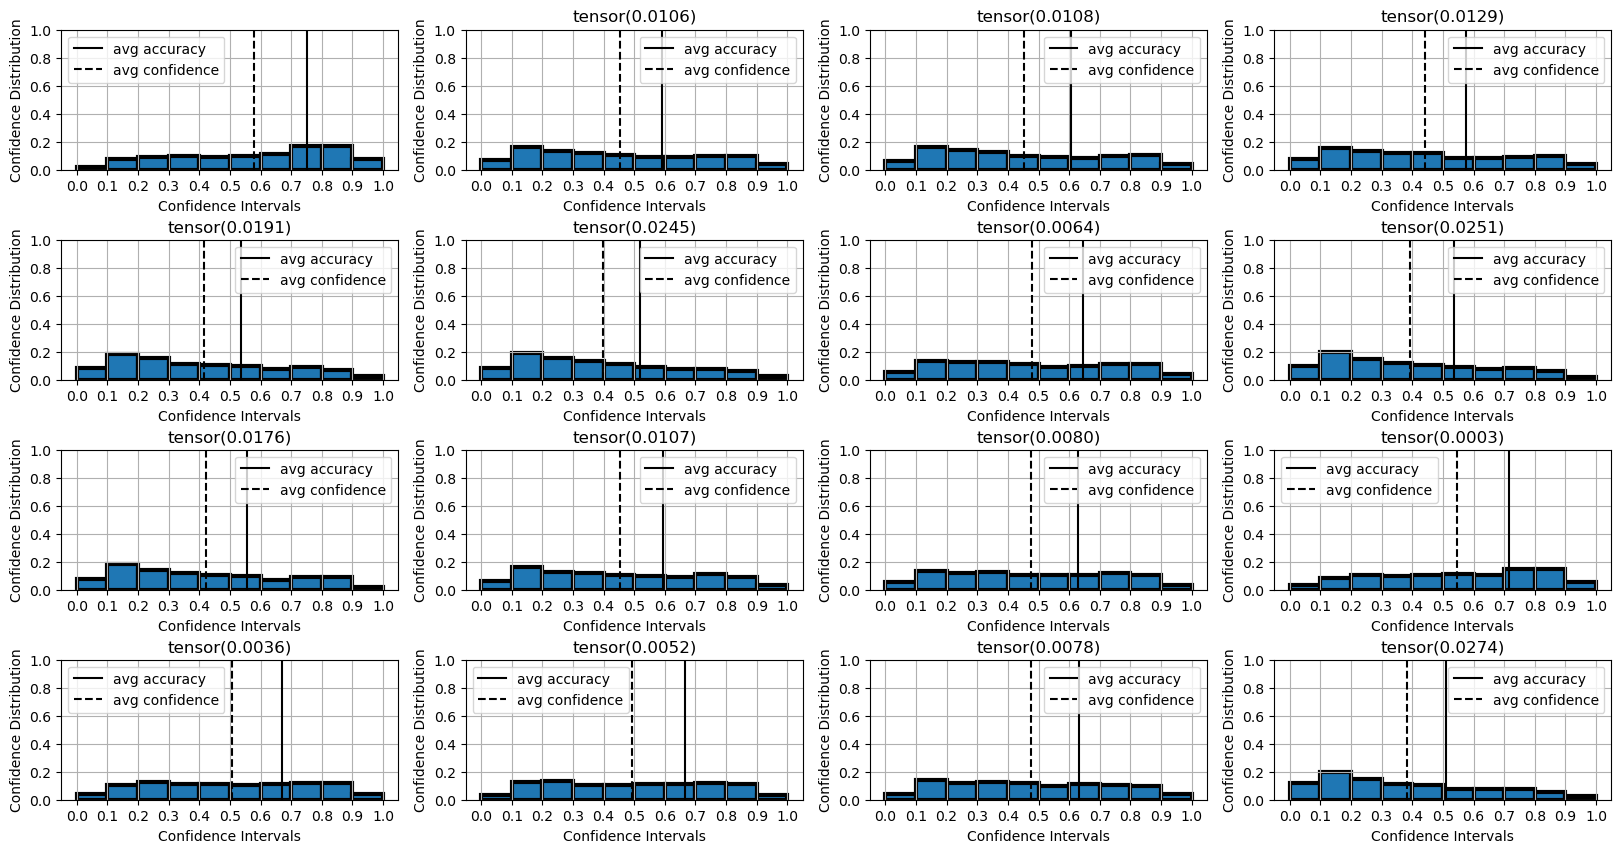

In [6]:
n_bins = 10
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
n = 50000
m = 2
rand_idx = torch.randperm(50000)[0:2000]
fig,ax = plt.subplots(4,4,figsize=(20,10))
clean_hist = None
fig.subplots_adjust(hspace=0.5)
for i in range(4):
    for j in range(4):
        if i*4+j == 0:
            accs,confs_hist,avg_confs,total_acc,total_avg_conf = get_corr(clean_confidences[rand_idx],clean_results[rand_idx])
            bar_ticks = np.arange(0,1+1*bin_uppers[0],1/n_bins)
            bar_ticks = [str(round(bar,2)) for bar in bar_ticks]
            bar_xpos = np.arange(0,n_bins+1)
            bar_xtickpos = [bar_xpos[i]-0.5 for i in range(len(bar_xpos))]
            ax[i,j].grid()
            ax[i,j].bar(bar_xpos[:-1],confs_hist,width=1,edgecolor = "black",linewidth=3)
            ax[i,j].set_xticks(bar_xtickpos, bar_ticks)
            ax[i,j].axvline(x = total_acc*n_bins-0.5, color = 'k', label = 'avg accuracy')
            ax[i,j].axvline(x = total_avg_conf*n_bins-0.5, color = 'k', label = 'avg confidence',linestyle="--")
            ax[i,j].legend()
            ax[i,j].set_xlabel("Confidence Intervals")
            ax[i,j].set_ylabel("Confidence Distribution")
            ax[i,j].set_ylim([0,1])
            # from torch.distributions import Categorical
            # ax[i,j].set_title(str(Categorical(probs = torch.tensor(confs_hist)).entropy()))
            clean_hist = confs_hist
        else:
            c = i*4+j-1
            accs,confs_hist,avg_confs,total_acc,total_avg_conf = get_corr(corr_confidences[n*c:n*c+n][rand_idx],corr_results[n*c:n*c+n][rand_idx])
            bar_ticks = np.arange(0,1+1*bin_uppers[0],1/n_bins)
            bar_ticks = [str(round(bar,2)) for bar in bar_ticks]
            bar_xpos = np.arange(0,n_bins+1)
            bar_xtickpos = [bar_xpos[i]-0.5 for i in range(len(bar_xpos))]
            ax[i,j].grid()
            ax[i,j].bar(bar_xpos[:-1],confs_hist,width=1,edgecolor = "black",linewidth=3)
            ax[i,j].set_xticks(bar_xtickpos, bar_ticks)
            ax[i,j].axvline(x = total_acc*n_bins-0.5, color = 'k', label = 'avg accuracy')
            ax[i,j].axvline(x = total_avg_conf*n_bins-0.5, color = 'k', label = 'avg confidence',linestyle="--")
            ax[i,j].legend()
            ax[i,j].set_xlabel("Confidence Intervals")
            ax[i,j].set_ylabel("Confidence Distribution")
            ax[i,j].set_ylim([0,1])
            # from torch.distributions import Categorical
            ax[i,j].set_title(str(F.kl_div(torch.log(torch.tensor(confs_hist)+0.001),torch.tensor(clean_hist))))
        # ax[i,j].set_xlim([-2.5,47.5])

### evaluating strategies for fixed model on corrupt set

In [20]:
# corr baseline
corr_online_acc = []
corr_online_efficiency = []
corr_online_acc64 = []
corr_online_efficiency64 = []
corr_online_ops = []
corr_online_ops64 = []

corr_policies = np.linspace(0,1,21)
corr_naive_online_acc = [[] for p in range(len(corr_policies))]
corr_naive_efficiency = [[] for p in range(len(corr_policies))]
corr_naive_ops = [[] for p in range(len(corr_policies))]

corr_oracle_acc = []
corr_oracle_efficiency = []
corr_oracle_ops = []
idxs = []

num_imgs = 0

corr_num_correct = 0
corr_num_correct64 = 0
corr_num_naive_correct = [0 for p in range(len(corr_policies))]
corr_num_oracle_correct = 0


corr_naive_num_wrong_decisions = 0
corr_naive_num_choose_small = [0 for p in range(len(corr_policies))]
corr_naive_num_choose_big = [0 for p in range(len(corr_policies))]

corr_oracle_num_choose_small = 0
corr_oracle_num_choose_big = 0

small_right_big_wrong = []
big_right_small_wrong = []

corr_overconfident_locations = [[] for p in range(len(corr_policies))]
corr_overconfident_imgs = []
corr_underconfident_locations = [[] for p in range(len(corr_policies))]
corr_underconfident_imgs = []
transition_points = [4]
corr_idx = 0
corr_img_count = 0

corr_sub_confs = torch.zeros(50000)
corr_sub_results = torch.zeros(50000)
corr_sub_confs64 = torch.zeros(50000)
corr_sub_results64 = torch.zeros(50000)

for sample_idx in tqdm(rand_order):
    # corruptions start after the first 2000 images
    if num_imgs-1 > 4:
        # each corruption lasts 3200 images
        if corr_img_count == 3333:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the prediction
        out = corr_confidences[rand_corr_order[corr_idx]*50000+sample_idx]
        out64 = corr_confidences64[rand_corr_order[corr_idx]*50000+sample_idx]
        res = corr_results[rand_corr_order[corr_idx]*50000+sample_idx]
        res64 = corr_results64[rand_corr_order[corr_idx]*50000+sample_idx]

        corr_sub_confs[num_imgs-1] = out
        corr_sub_confs64[num_imgs-1] = out64
        corr_sub_results[num_imgs-1] = res
        corr_sub_results64[num_imgs-1] = res64
        corr_img_count += 1
    else:
        # get the prediction
        out = clean_confidences[sample_idx]
        out64 = clean_confidences64[sample_idx]
        res = clean_results[sample_idx]
        res64 = clean_results64[sample_idx]
        
        corr_sub_confs[num_imgs-1] = out
        corr_sub_confs64[num_imgs-1] = out64
        corr_sub_results[num_imgs-1] = res
        corr_sub_results64[num_imgs-1] = res64

    num_imgs += 1
    
    corr_num_correct += res
    corr_num_correct64 += res64
    corr_online_acc.append(corr_num_correct/num_imgs)
    corr_online_acc64.append(corr_num_correct64/num_imgs)
    corr_online_efficiency.append(0)
    corr_online_efficiency64.append(1)
    corr_online_ops.append(234)
    corr_online_ops64.append(22)

    # oracle, if small is right choose small, else choose big
    if res64:
        corr_num_oracle_correct += res64
        corr_oracle_num_choose_small += 1
    else:
        corr_num_oracle_correct += res
        corr_oracle_num_choose_big += 1
    corr_oracle_acc.append(corr_num_oracle_correct/num_imgs) 
    corr_oracle_efficiency.append(corr_oracle_num_choose_small/num_imgs)   
    corr_oracle_ops.append((corr_oracle_num_choose_small*22+corr_oracle_num_choose_big*234)/num_imgs)

    if not res and res64:
        small_right_big_wrong.append(sample_idx)
    if not res64 and res:
        big_right_small_wrong.append(sample_idx)

    # naive strategy, if less than 50% confident, use big model
    for i,p in enumerate(corr_policies):
        if out64.item() < p:
            corr_num_naive_correct[i] += res
            corr_naive_num_choose_big[i] += 1
            # if was underconfident
            if res64:
                corr_naive_num_wrong_decisions += 1
                corr_underconfident_imgs.append(sample_idx)
                corr_underconfident_locations[i].append(num_imgs)
        else:
            corr_num_naive_correct[i] += res64
            corr_naive_num_choose_small[i] += 1
            # if was overconfident
            if not res64 and res:
                corr_naive_num_wrong_decisions += 1
                corr_overconfident_imgs.append(sample_idx)
                corr_overconfident_locations[i].append(num_imgs)
        corr_naive_online_acc[i].append(corr_num_naive_correct[i]/num_imgs)

    for i,p in enumerate(corr_policies):
        corr_naive_efficiency[i].append(corr_naive_num_choose_small[i]/num_imgs)
        corr_naive_ops[i].append((corr_naive_num_choose_small[i]*22+corr_naive_num_choose_big[i]*(234+22))/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:09<00:00, 5441.46it/s]


In [12]:
len(corr_underconfident_locations[4])

4022

### accuracy

(0.0, 1.0)

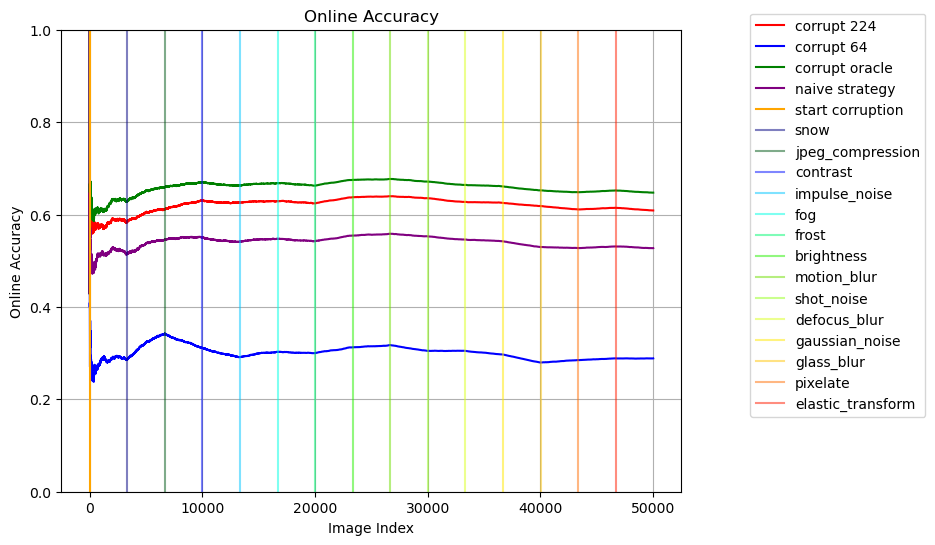

In [12]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_acc,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_acc64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_acc,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_online_acc[4],label='naive strategy',color='purple')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1])

### efficiency

(-0.1, 1.1)

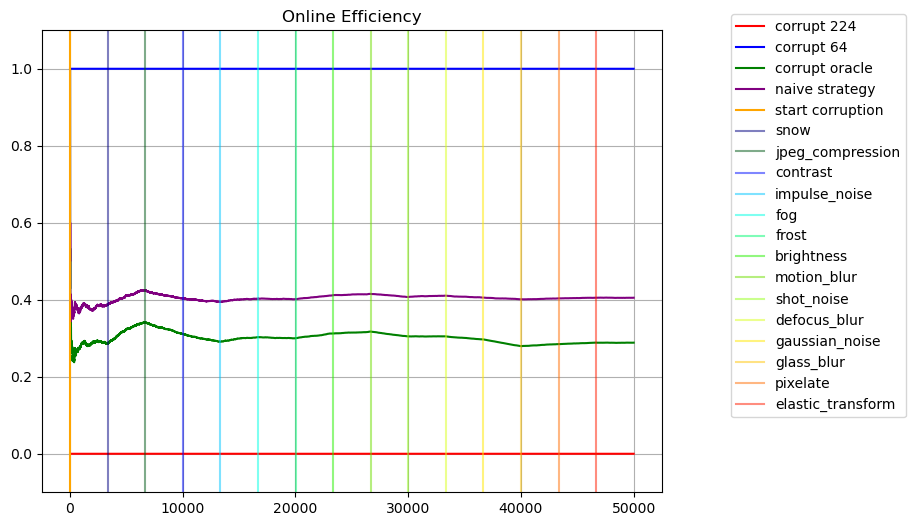

In [13]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_efficiency,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_efficiency64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_efficiency,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_efficiency[4],label='naive strategy',color='purple')
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Efficiency")
plt.ylim([-0.1,1.1])

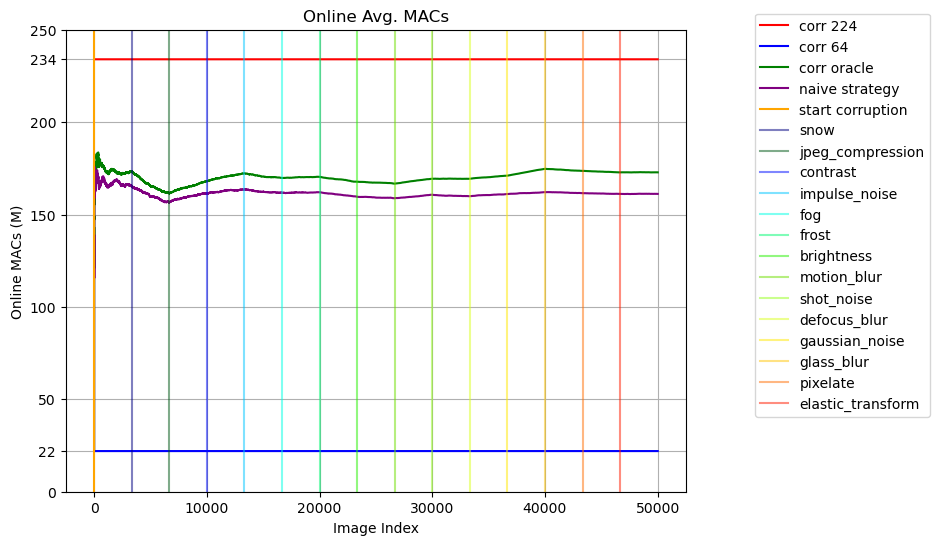

In [14]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_ops,label='corr 224',color='red')
ax1.plot(idxs,corr_online_ops64,label='corr 64',color='blue')
ax1.plot(idxs,corr_oracle_ops,label='corr oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_ops[4],label='naive strategy',color='purple')
plt.title("Online Avg. MACs")
ax1.axvline(x = transition_points[0], color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_yticks(list(plt.yticks()[0]) + [22,234])
ax1.set_ylabel("Online MACs (M)")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()

### pareto plot

In [1]:
efficiencies = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
acc_for_eff = []
big_model_idxs = [torch.zeros(len(corr_sub_results),dtype=torch.bool) for i in range(len(efficiencies))]
small_model_idxs = [torch.zeros(len(corr_sub_results),dtype=torch.bool) for i in range(len(efficiencies))]
for i,eff in enumerate(efficiencies):
    
    curr_acc = 0
    # choose only big
    if eff == 0:
        big_model_idxs[i][:] = True
        continue
    # choose only small
    if eff == 1:
        small_model_idxs[i][:] = True
        continue
    
    
    # for a given efficiency
    eff_thresh = int(eff*len(corr_sub_results))
    total_thresh = int(len(corr_sub_results))

    # get all idxs where small correct, big wrong
    small_correct_big_wrong_idxs = torch.logical_and((corr_sub_results64 == 1),(corr_sub_results == 0)).nonzero()

    # get all idxs where small and big correct
    small_big_correct_idxs = torch.logical_and((corr_sub_results64 == 1),(corr_sub_results == 1)).nonzero()

    # get all idxs where small wrong, big correct
    small_wrong_big_correct_idxs = torch.logical_and((corr_sub_results64 == 0),(corr_sub_results == 1)).nonzero()

    # get all idxs where big wrong and small wrong
    small_wrong_big_wrong_idxs = torch.logical_and((corr_sub_results64 == 0),(corr_sub_results == 0)).nonzero()
    
    curr_idxs = torch.clone(small_correct_big_wrong_idxs)

    # if above eff threshold (up to eff thresh is small, rest is big)
    if len(curr_idxs) > eff_thresh:
        # remove small until reach efficiency
        curr_idxs = curr_idxs[:eff_thresh]
        small_model_idxs[i][curr_idxs] = True # up until eff thresh

        # add big correct that hven't been taken
        taken = torch.zeros(len(corr_sub_results))
        taken[curr_idxs] = 1
        big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
        curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
        
        # if above total thresh
        if len(curr_idxs) > total_thresh:
            # remove some big to fit the threshold
            curr_idxs = curr_idxs[:total_thresh]
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
        else:
            # add some big wrong and small wrong to fit the threshold
            amnt = total_thresh - len(curr_idxs)
            taken = torch.zeros(len(corr_sub_results))
            taken[curr_idxs] = 1
            big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
            big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
            continue
    else: 
        # get more by adding predictions which both small and big correct
        curr_idxs = torch.cat((curr_idxs,small_big_correct_idxs))

        # if above efficicency threshold
        if len(curr_idxs) > eff_thresh:
            # remove some small/big correct
            curr_idxs = curr_idxs[:eff_thresh]
            small_model_idxs[i][curr_idxs] = True # up until eff thresh

            # add big correct that hven't been taken
            taken = torch.zeros(len(corr_sub_results))
            taken[curr_idxs] = 1
            big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
            curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))
            
            # if above total thresh
            if len(curr_idxs) > total_thresh:
                # remove some big to fit the threshold
                curr_idxs = curr_idxs[:total_thresh]
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
            else:
                # add some big wrong that doesn't conflict
                amnt = total_thresh - len(curr_idxs)
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                continue
        else:
            # add small wrong big wrong
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs))

            # if above eff thresh
            if len(curr_idxs) > eff_thresh:
                curr_idxs = curr_idxs[:eff_thresh]
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(corr_sub_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
            else:
                # add small wrong and big correct to reach eff thresh
                amnt = eff_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs[:amnt]))
                small_model_idxs[i][curr_idxs] = True # up until eff thresh

                # add big correct that hven't been taken
                taken = torch.zeros(len(corr_sub_results))
                taken[curr_idxs] = 1
                big_correct_no_conflict = torch.logical_and((corr_sub_results == 1),(taken == 0)).nonzero()
                curr_idxs = torch.cat((curr_idxs,big_correct_no_conflict))

                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue
                else:
                    # add some big wrong that haven't been taken
                    amnt = total_thresh - len(curr_idxs)
                    taken = torch.zeros(len(corr_sub_results))
                    taken[curr_idxs] = 1
                    big_incorrect_no_conflict = torch.logical_and((corr_sub_results == 0),(taken == 0)).nonzero()
                    curr_idxs = torch.cat((curr_idxs,big_incorrect_no_conflict[:amnt]))
                    big_model_idxs[i][curr_idxs[eff_thresh:]] = True # rest are big
                    continue

NameError: name 'torch' is not defined

In [329]:
acc_for_eff = []
for i, eff in enumerate(efficiencies):
    assert sum(small_model_idxs[i]).item() + sum(big_model_idxs[i]).item() == len(corr_sub_results) # total num predictions correct
    assert sum(torch.logical_and(small_model_idxs[5],big_model_idxs[5])).item() == 0 # no overlapping idxs
    acc_for_eff.append(((sum(corr_sub_results64[small_model_idxs[i]])+sum(corr_sub_results[big_model_idxs[i]]))/len(corr_sub_results)).item())

acc_eff_plot

(0.0, 1.0)

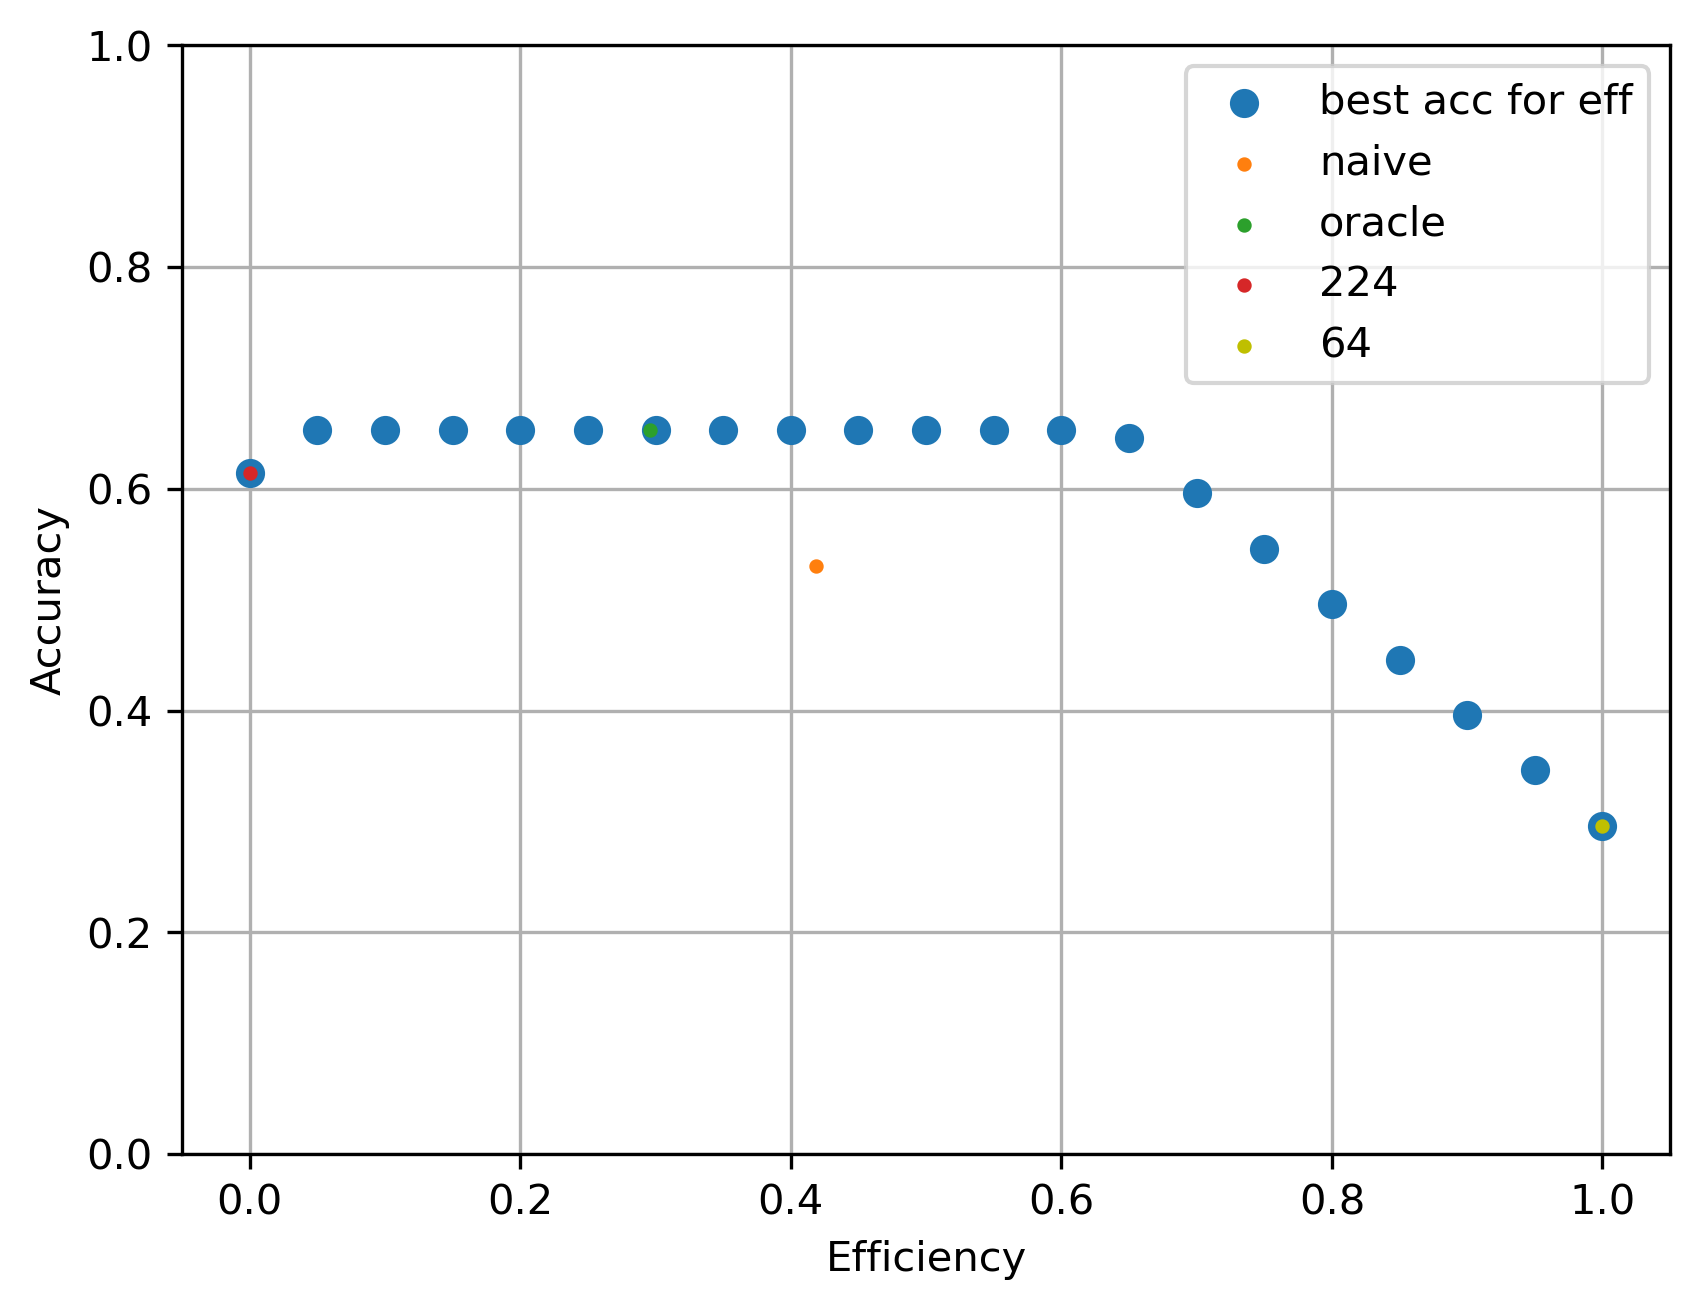

In [359]:
plt.scatter(efficiencies,acc_for_eff,label="best acc for eff")
plt.scatter(corr_naive_efficiency[-1],corr_naive_online_acc[-1],label="naive",s=6)
plt.scatter(corr_oracle_efficiency[-1],corr_oracle_acc[-1],label="oracle",s=6)
plt.scatter(corr_online_efficiency[-1],corr_online_acc[-1],label="224",s=6)
plt.scatter(corr_online_efficiency64[-1],corr_online_acc64[-1],label="64",s=6,c='y')
plt.grid()
plt.legend()
plt.xlabel("Efficiency")
plt.ylabel("Accuracy")
plt.ylim([0,1])

## Changing Models

### corrupt

#### KD and Nearest Class Mean

In [76]:
# KD, freeze layers
import copy
model64_KD = copy.deepcopy(model64)
model64_KD.eval()
model64_KD_o = copy.deepcopy(model64)
model64_KD_o.eval()
model64_KD_g = copy.deepcopy(model64)
model64_KD_g.eval()
model64_p = copy.deepcopy(model64)
model64_p.eval()
# # freeze parameters other than last layer
# for i,c in enumerate(model64_KD.children()):
#     if i == 2:
#         for param in c[0].parameters():
#             param.requires_grad = False
#     else:
#         for param in c.parameters():
#             param.requires_grad = False
# sum(p.numel() for p in model64_KD.parameters() if p.requires_grad)


# # NCM get embedding output
# register forward hook to get embedding output
# activationT = {}
activationS = {}
activationSp = {}
# def get_activationT(name):
#     def hook(model, input, output):
#         activationT[name] = output.detach()
#     return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook
def get_activationSp(name):
    def hook(model, input, output):
        activationSp[name] = output.detach()
    return hook

# get the activations
model.eval()
# model64.eval()
# model.classifier[0].register_forward_hook(get_activationT('emb'))
model64_KD_g.classifier[0].register_forward_hook(get_activationS('emb'))
model64_p.classifier[0].register_forward_hook(get_activationSp('emb'))
# class_means = torch.zeros((1000,1280))
# class_counts = torch.ones(1000)
# class_offset_means = torch.zeros((1000,1280))
# class_offset_counts = torch.zeros(1000)

# train_loader64, val_loader64 = load_imagenet64(64,12345)
# # train_loader, val_loader = load_imagenet(64,12345)
# for c_i in range(1000):
#     batch_imgs, batch_labels = next(iter(train_loader64))
#     idxs = (batch_labels == c_i).nonzero()[:15].view(-1)
#     imgs64 = batch_imgs[idxs].to('cuda')
#     # img = train_loader.dataset.dataset[idx][0].unsqueeze(0).to('cuda')
#     pred64 = model64(imgs64) 
#     # pred = model(img) 
#     class_means[c_i] = activationS['emb'].to('cpu').mean(dim=0)
#     # class_offset_means[c_i] = activationT['emb'].to('cpu')-activationS['emb'].to('cpu')

In [77]:
with torch.no_grad():
    print(F.softmax(model64(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
    print(F.softmax(model64_KD(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
    print(F.softmax(model64_KD_o(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
    print(F.softmax(model64_KD_g(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
    print(F.softmax(model64_p(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())

# from torch.utils.data import Subset

# from torch.utils.data.sampler import Sampler

# class CustomOrder(Sampler):
#     def __init__(self, dataset):
#         self.order = torch.randperm(len(dataset),)
        
#     def __iter__(self):
#         return iter(self.order)
    
#     def __len__(self):
#         return len(self.order)

# rand_order = CustomOrder(clean_val_loader.dataset)
# rand_corr_order = torch.randperm(15)

tensor(0.5287, device='cuda:0')
tensor(0.5287, device='cuda:0')
tensor(0.5287, device='cuda:0')
tensor(0.5287, device='cuda:0')
tensor(0.5287, device='cuda:0')


/tmp/ipykernel_1069666/647826049.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
/tmp/ipykernel_1069666/647826049.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64_KD(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
/tmp/ipykernel_1069666/647826049.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64_KD_o(clean_val_loader64.dataset[0][0].unsqueeze(0).to('cuda'))).max())
/tmp/ipykernel_1069666/647826049.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(model64_KD_g(clean_val_loader64.dataset[0][0].unsqueeze(0)

In [36]:
# corr baseline
corr_online_acc_KD = []
corr_online_efficiency_KD = []

corr_online_acc_KD_o = []
corr_online_efficiency_KD_o = []
corr_online_acc_KD_g = []
corr_online_efficiency_KD_g = []
corr_online_acc_p = []
corr_online_efficiency_p = []
# corr_online_acc_NCM = []
# corr_online_efficiency_NCM = []
corr_online_ops_KD = []
corr_online_ops_KD_o = []
corr_online_ops_KD_g = []
corr_online_ops_p = []
# corr_online_ops_NCM = []

idxs = []

num_imgs = 0

corr_num_correct_KD = 0
corr_num_correct_KD_o = 0
corr_num_correct_KD_g = 0
corr_num_correct_p = 0
# corr_num_correct_NCM = 0


# corr_num_wrong_decisions_KD = 0
corr_num_choose_small_KD = 0
corr_num_choose_big_KD = 0
corr_num_train_KD = 0

corr_num_choose_small_KD_o = 0
corr_num_choose_big_KD_o = 0
corr_num_train_KD_o = 0

corr_num_choose_small_KD_g = 0
corr_num_choose_big_KD_g = 0
corr_num_train_KD_g = 0

corr_num_choose_small_p = 0
corr_num_choose_big_p = 0
corr_num_train_p = 0
# corr_num_wrong_decisions_NCM = 0
# corr_num_choose_small_NCM = 0
# corr_num_choose_big_NCM = 0

# small_right_big_wrong = []
# big_right_small_wrong = []

# corr_overconfident_locations = []
# corr_overconfident_imgs = []
# corr_underconfident_locations = []
# corr_underconfident_imgs = []
transition_points = [4]
corr_idx = 0
corr_img_count = 0

opt = torch.optim.SGD(model64_KD.parameters(),lr=0.002)
opt_o = torch.optim.SGD(model64_KD_o.parameters(),lr=0.002)

class Gate(torch.nn.Module):
    def __init__(self):
      super(Gate, self).__init__()
      self.gate = torch.nn.Linear(1280,1)
    def forward(self,x):
        return F.sigmoid(self.gate(x))
gate = Gate().to('cuda')
opt_g = torch.optim.SGD(gate.parameters(),lr=0.005)

class FC(torch.nn.Module):
    def __init__(self):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(1280,1000)
    def forward(self,x):
      if len(x.shape) > 1:
        return F.softmax(self.c(x),dim=1)
      else:
        return F.softmax(self.c(x),dim=0)
fc64 = FC()

with torch.no_grad():
  fc64.c.weight[:,:] = model64_p.classifier[3].weight[:,:]
  fc64.c.bias[:] = model64_p.classifier[3].bias[:]
fc64 = fc64.to('cuda')
corr_st = False

train_on = False
train_iter = 0
train_on_o = False
train_iter_o = 0
train_on_g = False
train_iter_g = 0
grad_accum = 8
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 4:
        # each corruption lasts 3300 images
        if corr_img_count == 3333:
            corr_st = True
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction of small model
    out64 = model64_KD(img64.unsqueeze(0))
    conf64 = torch.max(F.softmax(out64))
    pred64 = out64.argmax(dim=1).item()
    res64 = (pred64 == target64.item())

    out64_o = model64_KD_o(img64.unsqueeze(0))
    pred64_o = out64_o.argmax(dim=1).item()
    res64_o = (pred64_o == target64.item())

    out64_g = model64_KD_g(img64.unsqueeze(0))
    pred64_g = out64_g.argmax(dim=1).item()
    res64_g = (pred64_g == target64.item())

    out64_p = model64_p(img64.unsqueeze(0))
    conf64_p = torch.max(F.softmax(out64_p))
    pred64_p = out64_p.argmax(dim=1).item()
    res64_p = (pred64_p == target64.item())
    # get the embedding
    # out64_dummy = model64(img64.unsqueeze(0))
    # model64_emb = activationS['emb'].to('cpu')

    # get class with the closest mean (using student emb)
    # ncs = (((class_means+class_offset_means)-model64_emb).pow(2).sum(dim=1).sqrt()).argmin()
    # use teach 25% of the time
    # if torch.rand(1) > 0.75 and num_imgs-1 > 1999:
    #     corr_num_choose_big_NCM += 1
    #     with torch.no_grad():
    #         # get teacher pred and emb
    #         nct = model(img.unsqueeze(0)).argmax(dim=1).item()
    #         # model_emb = activationT['emb'].to('cpu')
    #         class_counts[nct] += 1
    #         class_offset_counts[nct] += 1
    #         # update class mean normally
    #         class_offset_means[nct,:] = (class_offset_means[nct,:] + (model64_emb - class_means[nct,:]))/class_offset_counts[nct]
    #         class_means[nct,:] = (class_means[nct,:] + model64_emb)/class_counts[nct] #+ 0.95*model_emb
            
    #         corr_num_correct_NCM += (nct == target64.item())
    #     if (ncs == target64.item()):
    #         corr_num_wrong_decisions_NCM += 1
    # else:
    #     corr_num_choose_small_NCM += 1
    #     corr_num_correct_NCM += (ncs == target64.item())
    #     # otherwise use small model ncm
    #     class_counts[ncs] += 1
    #     class_means[ncs,:] = (class_means[ncs,:] + model64_emb)/class_counts[ncs]
    
    # corr_online_efficiency.append(0)
    # corr_online_efficiency64.append(1)
    # corr_online_ops.append(234)
    # corr_online_ops64.append(22)

    # naive strategy, if less than 50% confident, use big model
    # conf64 = torch.nn.Softmax()(out64).max().item() 
    # print(conf64)
    # if conf64 < 0.50:
    if (corr_img_count > 0) and (((corr_img_count % grad_accum) == 0) and (corr_img_count < grad_accum*64)):
        # print("train oracle:",corr_img_count)
        train_on_o = True
    
    # if not currently training, then start training for grad_accum iterations
    if conf64.item() < 0.3:#corr_img_count >= 1 and corr_img_count <= 64:#torch.rand(1) > 0.9 and num_imgs-1 > 1999:
        train_on = True
        # print("turn rain on")

    # choose teacher based on policy or random chance
    d = gate(activationS['emb'])
    if d > 0.5:
        train_on_g = True

    # student unconfident
    if conf64_p < 0.5:
        # check perturbation sequence
        emb = activationSp['emb']
        count = 0
        for i in range(3):
            noise64 = torch.normal(0,0.72,size=(1,1280)).view(-1).to('cuda')
            p_out = fc64(emb+noise64)
            if p_out.argmax().item() == pred64_p:
                count += 1
        if count == 3:
            corr_num_correct_p += res64_p
            corr_num_choose_small_p += 1
        else:
            with torch.no_grad():
                out = model(img.unsqueeze(0))
                conf = torch.max(F.softmax(out))
                pred = out.argmax(dim=1).item()
                res = (pred == target.item())
                corr_num_correct_p += res
            corr_num_choose_big_p += 1
        corr_num_train_p += 1
    else:
        corr_num_correct_p += res64_p
        corr_num_choose_small_p += 1
        

    # training is currently on
    if train_on:
        # big model forward
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
            pred = out.argmax(dim=1).item()
            res = (pred == target.item())
            corr_num_correct_KD += res
        # only do KD on confident images
        if conf.item() > 0.6:
            # do KD
            T = 5
            alpha = 0.9
            loss_KD = nn.KLDivLoss()(F.log_softmax(out64/T, dim=1),
                                    F.softmax(out/T, dim=1))* (alpha * T * T) + \
                            F.cross_entropy(out64, torch.tensor(pred).unsqueeze(0).to('cuda')) * (1. - alpha)
            loss_KD.backward()

            # after grad_acum iterations, take a step and stop training
            if ((train_iter + 1) % grad_accum == 0):
                opt.step()
                opt.zero_grad()
                train_iter = 0
                # print("accumulate")

            train_iter += 1
            train_on = False
            corr_num_train_KD += 1
        # print("trained iter:", train_iter)
        train_on = False

        # get the T embedding
        # model_emb = activationT['emb'].to('cpu')
        # class_counts[pred] += 1
        # class_means[pred,:] = 0.8*(class_means[pred,:] + model64_emb)/class_counts[pred] + 0.2*model_emb


        corr_num_choose_big_KD += 1
        # if was underconfident
        # if res64:
        #     corr_num_wrong_decisions_KD += 1
    else:
        # class_counts[nc] += 1
        # class_means[nc,:] = (class_means[pred,:] + model64_emb)/class_counts[nc]
        # corr_num_correct_NCM += (nc == target64.item())
        corr_num_correct_KD += res64
        corr_num_choose_small_KD += 1
        # if was overconfident
        # if not res64 and res:
        #     corr_num_wrong_decisions_KD += 1


    # training is currently on
    if train_on_o:
        # big model forward
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
        pred = out.argmax(dim=1).item()
        res = (pred == target.item())
        corr_num_correct_KD_o += res

        if conf.item() > 0.6:
            # do KD
            T = 5
            alpha = 0.9
            loss_KD_o = nn.KLDivLoss()(F.log_softmax(out64_o/T, dim=1),
                                    F.softmax(out/T, dim=1))* (alpha * T * T) + \
                            F.cross_entropy(out64_o, torch.tensor(pred).unsqueeze(0).to('cuda')) * (1. - alpha)
            loss_KD_o.backward()

            # after grad_acum iterations, take a step and stop training
            if ((train_iter_o + 1) % grad_accum == 0):
                opt_o.step()
                opt_o.zero_grad()
                train_iter_o = 0
                train_on_o = False
                # print("accumulate")

            train_iter_o += 1
            corr_num_train_KD_o += 1
        # print("trained iter:", train_iter)

        # get the T embedding
        # model_emb = activationT['emb'].to('cpu')
        # class_counts[pred] += 1
        # class_means[pred,:] = 0.8*(class_means[pred,:] + model64_emb)/class_counts[pred] + 0.2*model_emb


        corr_num_choose_big_KD_o += 1
        # if was underconfident
        # if res64:
        #     corr_num_wrong_decisions_KD += 1
    else:
        # class_counts[nc] += 1
        # class_means[nc,:] = (class_means[pred,:] + model64_emb)/class_counts[nc]
        # corr_num_correct_NCM += (nc == target64.item())
        corr_num_correct_KD_o += res64_o
        corr_num_choose_small_KD_o += 1
        # if was overconfident
        # if not res64 and res:
        #     corr_num_wrong_decisions_KD += 1

    if train_on_g:
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
            pred = out.argmax(dim=1).item()
            res = (pred == target.item())
            corr_num_correct_KD_g += res
            
        # if predictions don't match, then we want the teacher (l = 1)
        l = torch.tensor(int(pred != pred64_g)).float()
        # loss_g = F.cross_entropy(d,l.unsqueeze(0).to('cuda'))
        loss_g = F.binary_cross_entropy(d.view(-1)[0],l.to('cuda'))
        loss_g.backward()

        # after grad_acum iterations, take a step and stop training
        if ((train_iter_g + 1) % grad_accum == 0):
            opt_g.step()
            opt_g.zero_grad()
            train_iter_g = 0
            train_on_o = False
            # print("accumulate")

        train_iter_g += 1
        corr_num_train_KD_g += 1 
        train_on_g = False      
        corr_num_choose_big_KD_g += 1
    else:
        corr_num_correct_KD_g += res64_g
        corr_num_choose_small_KD_g += 1

    corr_online_acc_KD.append(corr_num_correct_KD/num_imgs)
    corr_online_efficiency_KD.append(corr_num_choose_small_KD/num_imgs)
    corr_online_ops_KD.append((corr_num_choose_small_KD*22+corr_num_choose_big_KD*(234+22)+corr_num_train_KD*(22*2))/num_imgs)

    corr_online_acc_KD_o.append(corr_num_correct_KD_o/num_imgs)
    corr_online_efficiency_KD_o.append(corr_num_choose_small_KD_o/num_imgs)
    corr_online_ops_KD_o.append((corr_num_choose_small_KD_o*22+corr_num_choose_big_KD_o*(234+22)+corr_num_train_KD_o*(22*2))/num_imgs)

    corr_online_acc_KD_g.append(corr_num_correct_KD_g/num_imgs)
    corr_online_efficiency_KD_g.append(corr_num_choose_small_KD_g/num_imgs)
    corr_online_ops_KD_g.append((corr_num_choose_small_KD_g*22+corr_num_choose_big_KD_g*(234+22)+corr_num_train_KD_g*(0))/num_imgs)

    corr_online_acc_p.append(corr_num_correct_p/num_imgs)
    corr_online_efficiency_p.append(corr_num_choose_small_p/num_imgs)
    corr_online_ops_p.append((corr_num_choose_small_p*22+corr_num_choose_big_p*(234+22)+corr_num_train_p*(3.84))/num_imgs)

    # corr_online_acc_NCM.append(corr_num_correct_NCM/num_imgs)
    # corr_online_efficiency_NCM.append(corr_num_choose_small_NCM/num_imgs)
    # corr_online_ops_NCM.append((corr_num_choose_small_NCM*22+corr_num_choose_big_NCM*234)/num_imgs)
    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_1069666/294323270.py:122: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf64 = torch.max(F.softmax(out64))
/tmp/ipykernel_1069666/294323270.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf64_p = torch.max(F.softmax(out64_p))
/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_1069666/294323270.py:324: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf = torch.max(F.softmax(out))
  0%|          | 6/50000 [00:00<31:38, 26.33it/s]/tmp/ipykernel_1069666/294323270.py:206: UserWarning: Impl

only gate

In [227]:
# all confs and results on corrupted sets
corr_confidences = torch.load("accs/corr_confs224.pt")
corr_results = torch.load("accs/corr_results224.pt")
corr_confidences64 = torch.load("accs/corr_confs64.pt")
corr_results64 = torch.load("accs/corr_results64.pt")

corr_online_acc_KD_g = []
corr_online_efficiency_KD_g = []
corr_online_ops_KD_g = []

corr_online_acc_p = []
corr_online_efficiency_p = []
corr_online_ops_p = []


idxs = []

num_imgs = 0
corr_num_correct_KD_g = 0

corr_num_choose_small_KD_g = 0
corr_num_choose_big_KD_g = 0
corr_num_train_KD_g = 0

corr_num_correct_p = 0

corr_num_choose_small_p = 0
corr_num_choose_big_p = 0
corr_num_train_p = 0

transition_points = [4]
corr_idx = 0
corr_img_count = 0

class Gate(torch.nn.Module):
    def __init__(self):
      super(Gate, self).__init__()
      self.gate = torch.nn.Linear(1280,1)
    def forward(self,x):
        return F.sigmoid(self.gate(x))
gate = Gate().to('cuda')
opt_g = torch.optim.SGD(gate.parameters(),lr=0.125,momentum=0.9)
corr_st = False

train_on_g = False
train_iter_g = 0
grad_accum = 64
Sp = []
Tp = []
ls = []
ds = []
cs_mean_emb = torch.zeros((1280,1)).view(-1)
ct_mean_emb = torch.zeros((1280,1)).view(-1)
alpha = 0.5
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 4:
        # each corruption lasts 3300 images
        if corr_img_count == 3333:
            corr_st = True
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction of small model
    out64_g = model64_KD_g(img64.unsqueeze(0))
    pred64_g = out64_g.argmax(dim=1).item()
    res64_g = (pred64_g == target64.item())

    # get cos sim to cs and ct centroids
    emb64 = activationS['emb'].to('cpu')
    cs_sim = (emb64@cs_mean_emb.T)/(torch.norm(emb64)*torch.norm(cs_mean_emb))
    ct_sim = (emb64@ct_mean_emb.T)/(torch.norm(emb64)*torch.norm(ct_mean_emb))
    # if ct centroid closer, choose teacher
    if cs_sim < ct_sim:
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
            pred = out.argmax(dim=1).item()
            res = (pred == target.item())
        corr_num_correct_p += res     
        corr_num_choose_big_p += 1
        # if student and teacher predictions matched, update student centroid, else the teacher
        if pred == pred64_g:
            cs_mean_emb = alpha*cs_mean_emb + (1-alpha)*emb64
        else:
            ct_mean_emb = alpha*ct_mean_emb + (1-alpha)*emb64

    else:
        cs_mean_emb = alpha*cs_mean_emb + (1-alpha)*emb64
        corr_num_correct_p += res64_g
        corr_num_choose_small_p += 1

    
    corr_online_acc_p.append(corr_num_correct_p/num_imgs)
    corr_online_efficiency_p.append(corr_num_choose_small_p/num_imgs)
    corr_online_ops_p.append((corr_num_choose_small_p*22+corr_num_choose_big_p*(234+22))/num_imgs)


    # choose teacher based on policy or random chance
    d = gate(activationS['emb'])
    if d > 0.5 or torch.rand(1) < 0.025:
        train_on_g = True
        

    if train_on_g:
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
            pred = out.argmax(dim=1).item()
            res = (pred == target.item())
            corr_num_correct_KD_g += res
            
        # if predictions don't match, then we want the teacher (l = 1)
        l = torch.tensor(int(pred != pred64_g)).float()
        # loss_g = F.cross_entropy(d,l.unsqueeze(0).to('cuda'))
        loss_g = F.binary_cross_entropy(d.view(-1)[0],l.to('cuda'))
        loss_g = loss_g/grad_accum
        loss_g.backward()
        ds.append(d)
        Sp.append(pred64_g)
        Tp.append(pred)
        ls.append(loss_g)

        # after grad_acum iterations, take a step and stop training
        if ((train_iter_g + 1) % grad_accum == 0):
            opt_g.step()
            opt_g.zero_grad()
            train_iter_g = 0
            train_on_o = False
            # print("accumulate")

        train_iter_g += 1
        corr_num_train_KD_g += 1 
        train_on_g = False      
        corr_num_choose_big_KD_g += 1
    else:
        corr_num_correct_KD_g += res64_g
        corr_num_choose_small_KD_g += 1

    
    corr_online_acc_KD_g.append(corr_num_correct_KD_g/num_imgs)
    corr_online_efficiency_KD_g.append(corr_num_choose_small_KD_g/num_imgs)
    corr_online_ops_KD_g.append((corr_num_choose_small_KD_g*22+corr_num_choose_big_KD_g*(234+22)+corr_num_train_KD_g*(0))/num_imgs)

    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_653970/3581783877.py:122: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf = torch.max(F.softmax(out))
100%|██████████| 50000/50000 [07:01<00:00, 118.63it/s]


need to look at stream of S and T predictions along with loss and d values to see how stream is changing

In [144]:
for i in range(100):
    print(ds[i],Sp[i],Tp[i],ls[i])

tensor([[0.5026]], device='cuda:0', grad_fn=<SigmoidBackward0>) 104 86 tensor(0.0430, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.6305]], device='cuda:0', grad_fn=<SigmoidBackward0>) 343 343 tensor(0.0622, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.4442]], device='cuda:0', grad_fn=<SigmoidBackward0>) 741 741 tensor(0.0367, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.6333]], device='cuda:0', grad_fn=<SigmoidBackward0>) 135 956 tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.5656]], device='cuda:0', grad_fn=<SigmoidBackward0>) 49 49 tensor(0.0521, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.5817]], device='cuda:0', grad_fn=<SigmoidBackward0>) 748 551 tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.5366]], device='cuda:0', grad_fn=<SigmoidBackward0>) 341 43 tensor(0.0389, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.5693]], device='cuda:0', grad_fn=<SigmoidBackward0>) 260 259 tensor(0.0352, device='cuda:0', grad

random policy

In [24]:
# all confs and results on corrupted sets
corr_confidences = torch.load("accs/corr_confs224.pt")
corr_results = torch.load("accs/corr_results224.pt")
corr_confidences64 = torch.load("accs/corr_confs64.pt")
corr_results64 = torch.load("accs/corr_results64.pt")
# clean_results = torch.load("accs/clean_confs224.pt")
# clean_results64 = torch.load("accs/clean_confs64.pt")


idxs = []

num_imgs = 0

transition_points = [4]
corr_idx = 0
corr_img_count = 0

corr_st = False

rand_policies = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
corr_rand_online_acc = [[] for p in range(len(rand_policies))]
corr_rand_efficiency = [[] for p in range(len(rand_policies))]
corr_rand_ops = [[] for p in range(len(rand_policies))]

clean_rand_online_acc = [[] for p in range(len(rand_policies))]
clean_rand_efficiency = [[] for p in range(len(rand_policies))]
clean_rand_ops = [[] for p in range(len(rand_policies))]

corr_num_rand_correct = [0 for p in range(len(rand_policies))]

corr_rand_num_choose_small = [0 for p in range(len(rand_policies))]
corr_rand_num_choose_big = [0 for p in range(len(rand_policies))]

clean_num_rand_correct = [0 for p in range(len(rand_policies))]

clean_rand_num_choose_small = [0 for p in range(len(rand_policies))]
clean_rand_num_choose_big = [0 for p in range(len(rand_policies))]

# corr_overconfident_locations = [[] for p in range(len(corr_policies))]
# corr_overconfident_imgs = []
# corr_underconfident_locations = [[] for p in range(len(corr_policies))]


for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 4:
        # each corruption lasts 3300 images
        if corr_img_count == 3333:
            corr_st = True
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        conf = corr_confidences[rand_corr_order[corr_idx]*50000+sample_idx]
        conf64 = corr_confidences64[rand_corr_order[corr_idx]*50000+sample_idx]
        res = corr_results[rand_corr_order[corr_idx]*50000+sample_idx]
        res64 = corr_results64[rand_corr_order[corr_idx]*50000+sample_idx]
        corr_img_count += 1
    else:
        conf = clean_confidences[sample_idx]
        conf64 = clean_confidences64[sample_idx]
        res = clean_results[sample_idx]
        res64 = clean_results64[sample_idx]

    num_imgs += 1

    clean_conf = clean_confidences[sample_idx]
    clean_conf64 = clean_confidences64[sample_idx]
    clean_res = clean_results[sample_idx]
    clean_res64 = clean_results64[sample_idx]
        
    for i,p in enumerate(rand_policies):
        if torch.rand(1) > p:
            corr_num_rand_correct[i] += res     
            corr_rand_num_choose_big[i] += 1
            clean_num_rand_correct[i] += clean_res     
            clean_rand_num_choose_big[i] += 1
        else:
            corr_num_rand_correct[i] += res64
            corr_rand_num_choose_small[i] += 1
            clean_num_rand_correct[i] += clean_res64
            clean_rand_num_choose_small[i] += 1

        
        corr_rand_online_acc[i].append(corr_num_rand_correct[i]/num_imgs)
        corr_rand_efficiency[i].append(corr_rand_num_choose_small[i]/num_imgs)
        corr_rand_ops[i].append((corr_rand_num_choose_small[i]*22+corr_rand_num_choose_big[i]*(234))/num_imgs)

        clean_rand_online_acc[i].append(clean_num_rand_correct[i]/num_imgs)
        clean_rand_efficiency[i].append(clean_rand_num_choose_small[i]/num_imgs)
        clean_rand_ops[i].append((clean_rand_num_choose_small[i]*22+clean_rand_num_choose_big[i]*(234))/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:10<00:00, 4606.82it/s]


(0.0, 1.0)

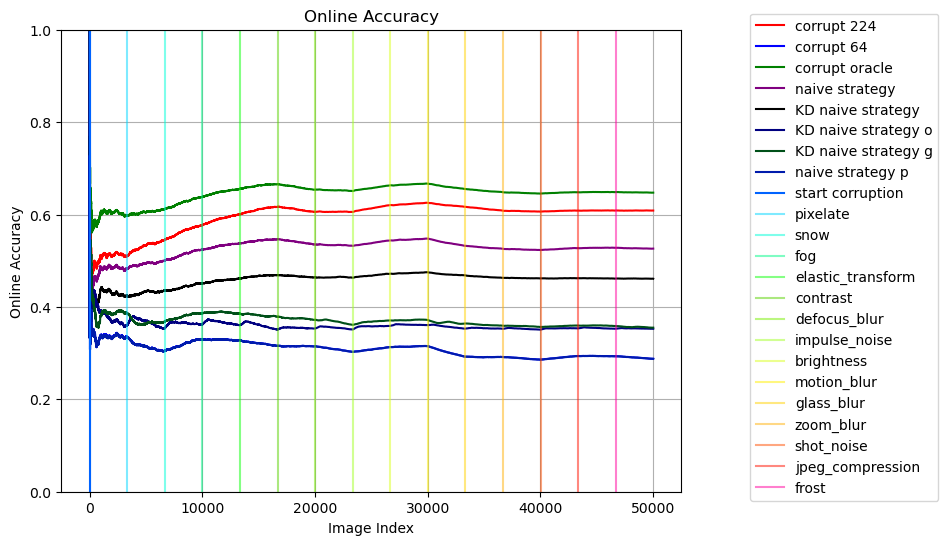

In [228]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_acc,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_acc64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_acc,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_online_acc[4],label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_acc_KD,label='KD naive strategy',color='black')
ax1.plot(idxs,corr_online_acc_KD_o,label='KD naive strategy o',color='yellow')
ax1.plot(idxs,corr_online_acc_KD_g,label='KD naive strategy g',color='yellow')
ax1.plot(idxs,corr_online_acc_p,label='naive strategy p',color='yellow')
# ax1.plot(idxs,corr_online_acc_NCM,label='NCM naive strategy',color='orange')
ax1.axvline(x = 4, color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1])

(-0.1, 1.1)

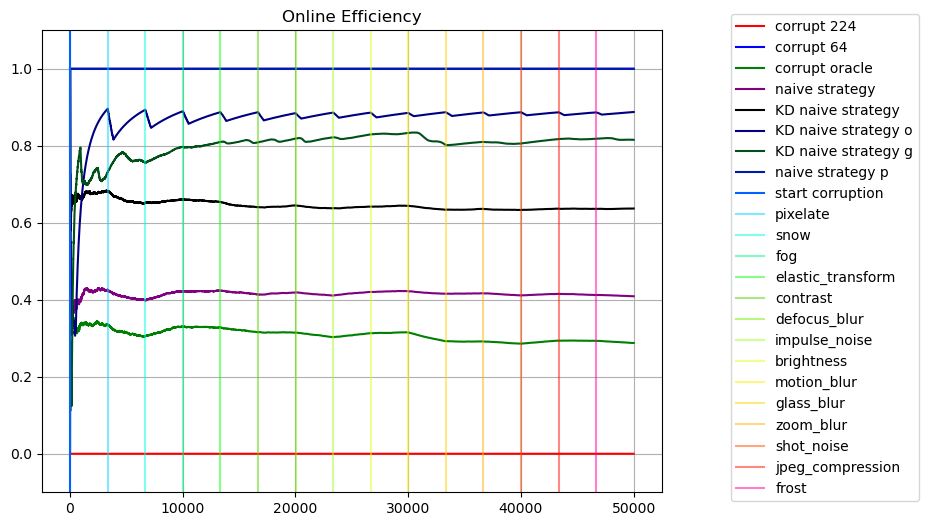

In [229]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_efficiency,label='corrupt 224',color='red')
ax1.plot(idxs,corr_online_efficiency64,label='corrupt 64',color='blue')
ax1.plot(idxs,corr_oracle_efficiency,label='corrupt oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_efficiency[4],label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_efficiency_KD,label='KD naive strategy',color='black')
ax1.plot(idxs,corr_online_efficiency_KD_o,label='KD naive strategy o',color='yellow')
ax1.plot(idxs,corr_online_efficiency_KD_g,label='KD naive strategy g',color='yellow')
ax1.plot(idxs,corr_online_efficiency_p,label='naive strategy p',color='yellow')
# ax1.plot(idxs,corr_online_efficiency_NCM,label='NCM naive strategy',color='orange')
ax1.axvline(x = 4, color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Efficiency")
plt.ylim([-0.1,1.1])

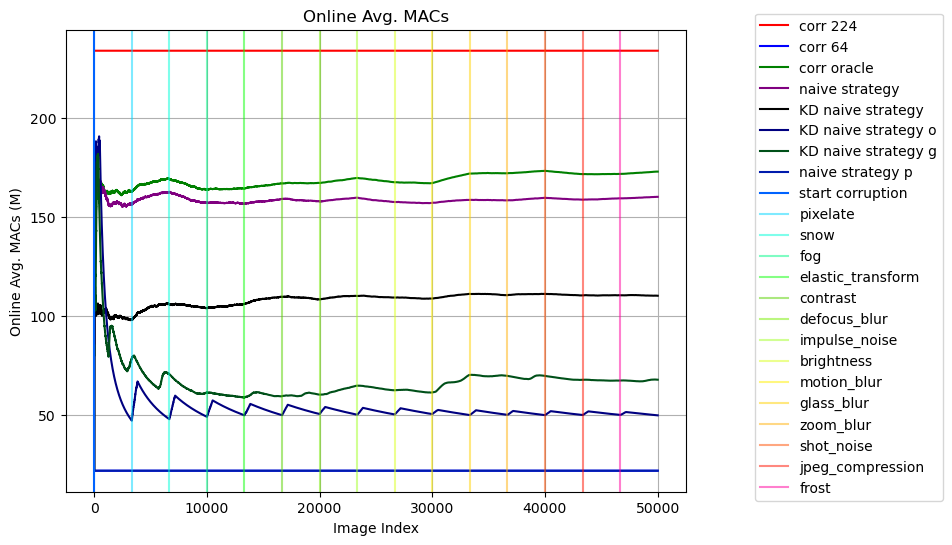

In [225]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,corr_online_ops,label='corr 224',color='red')
ax1.plot(idxs,corr_online_ops64,label='corr 64',color='blue')
ax1.plot(idxs,corr_oracle_ops,label='corr oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,corr_naive_ops[4],label='naive strategy',color='purple')
ax1.plot(idxs,corr_online_ops_KD,label='KD naive strategy',color='black')
ax1.plot(idxs,corr_online_ops_KD_o,label='KD naive strategy o',color='yellow')
ax1.plot(idxs,corr_online_ops_KD_g,label='KD naive strategy g',color='yellow')
ax1.plot(idxs,corr_online_ops_p,label='naive strategy p',color='yellow')
plt.title("Online Avg. MACs")
ax1.axvline(x = 4, color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points[1:]):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Avg. MACs (M)")
# ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")
plt.grid()

In [123]:
# corr baseline
corr_online_acc_p = []
corr_online_efficiency_p = []
corr_online_ops_p = []

corr_online_acc_p2 = []
corr_online_efficiency_p2 = []
corr_online_ops_p2 = []

idxs = []

num_imgs = 0

corr_num_correct_p = 0
corr_num_choose_small_p = 0
corr_num_choose_big_p = 0
corr_num_train_p = 0

corr_num_correct_p2 = 0
corr_num_choose_small_p2 = 0
corr_num_choose_big_p2 = 0
corr_num_train_p2 = 0

transition_points = [4]
corr_idx = 0
corr_img_count = 0

num_rob = 0
num_rob_correct = 0
_5_correct64 = 0
_5_correct = 0

class FC(torch.nn.Module):
    def __init__(self):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(1280,1000)
    def forward(self,x):
      if len(x.shape) > 1:
        return F.softmax(self.c(x),dim=1)
      else:
        return F.softmax(self.c(x),dim=0)
fc64 = FC()

with torch.no_grad():
  fc64.c.weight[:,:] = model64_p.classifier[3].weight[:,:]
  fc64.c.bias[:] = model64_p.classifier[3].bias[:]
fc64 = fc64.to('cuda')


for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 4:
        # each corruption lasts 3300 images
        if corr_img_count == 3333:
            corr_st = True
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    with torch.no_grad():
        out64_p = model64_p(img64.unsqueeze(0))
        conf64_p = torch.max(F.softmax(out64_p))
        pred64_p = out64_p.argmax(dim=1).item()
        res64_p = (pred64_p == target64.item())
    

    # student unconfident
    if conf64_p < 0.85:
        with torch.no_grad():
            out = model(img.unsqueeze(0))
            conf = torch.max(F.softmax(out))
            pred = out.argmax(dim=1).item()
            res = (pred == target.item())
            corr_num_correct_p2 += res
            corr_num_choose_big_p2 += 1
        # check perturbation sequence
        emb = activationSp['emb']
        # print("corr_idx:",rand_corr_order[corr_idx]," idx:",sample_idx)
        # print("emb:", emb)
        # print("conf:",conf64_p)
        # print("pred:",pred64_p)
        count = 0
        for i in range(3):
            noise64 = torch.normal(0,0.72,size=(1,1280)).view(-1).to('cuda')
            p_out = fc64(emb+noise64)
            if p_out.argmax().item() == pred64_p:
                count += 1
            else:
                # print("corr_idx:",rand_corr_order[corr_idx]," idx:",sample_idx)
                # print("emb:", emb)
                # print("conf:",conf64_p)
                # print("pred:",pred64_p)
                # print(fc64(emb))
                # print("noise:",noise64)
                # print("out:",p_out)
                # print(torch.argmax(p_out))
                # print(torch.std(emb+noise64))
                break
        if count == 3:
            corr_num_correct_p += res64_p
            corr_num_choose_small_p += 1
            num_rob += 1
            num_rob_correct += res64_p
        else:
            corr_num_correct_p += res
            corr_num_choose_big_p += 1
        corr_num_train_p += 1
        _5_correct64 += res64_p
        _5_correct += res
    else:
        corr_num_correct_p += res64_p
        corr_num_choose_small_p += 1
        corr_num_correct_p2 += res64_p
        corr_num_choose_small_p2 += 1
        
    corr_online_acc_p.append(corr_num_correct_p/num_imgs)
    corr_online_efficiency_p.append(corr_num_choose_small_p/num_imgs)
    corr_online_ops_p.append((corr_num_choose_small_p*22+corr_num_choose_big_p*(234+22)+corr_num_train_p*(3.84))/num_imgs)
    
    corr_online_acc_p2.append(corr_num_correct_p2/num_imgs)
    corr_online_efficiency_p2.append(corr_num_choose_small_p2/num_imgs)
    corr_online_ops_p2.append((corr_num_choose_small_p2*22+corr_num_choose_big_p2*(234+22)+corr_num_train_p2*(0))/num_imgs)

    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_1069666/805508001.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf64_p = torch.max(F.softmax(out64_p))
/tmp/ipykernel_1069666/805508001.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  conf = torch.max(F.softmax(out))
100%|██████████| 50000/50000 [08:00<00:00, 104.13it/s]


In [124]:
print("num swapped:",num_rob)
print("num swapped correct:",num_rob_correct, " rate:",num_rob_correct/num_rob)
print("stud correct:",_5_correct64, " rate:",_5_correct64/corr_num_train_p)
print("teach correct:",_5_correct, " rate:",_5_correct/corr_num_train_p)

num swapped: 7291
num swapped correct: 2523  rate: 0.3460430667946784
stud correct: 9093  rate: 0.21151922584847285
teach correct: 24592  rate: 0.5720533159645491


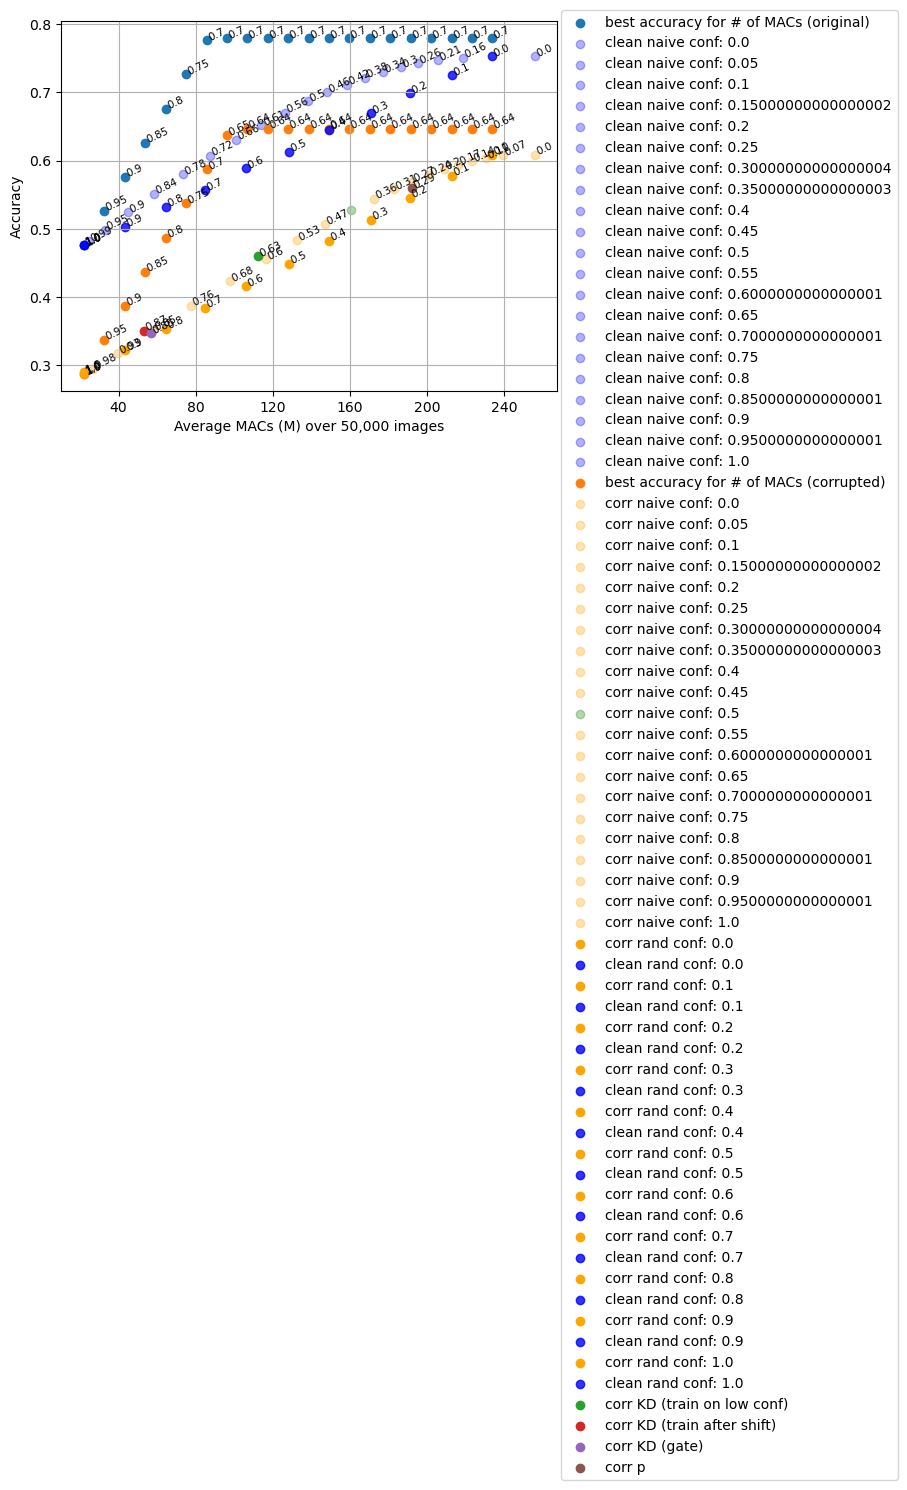

In [125]:
accs2 = [acc/50000 for acc in accs]
corr_accs2 = [acc/50000 for acc in corr_accs]
fig,ax1 = plt.subplots()

# ax1.scatter(clean_online_ops64[-1]*50000,clean_online_acc64[-1],label = "clean 64")
# ax1.annotate(round(clean_online_efficiency64[-1],2),(clean_online_ops64[-1]*50000,clean_online_acc64[-1]-.02),rotation=0, size=7.5)

ax1.scatter(ops,accs2,label="best accuracy for # of MACs (original)")
for i,p in enumerate(policies):
    ax1.scatter(clean_naive_ops[i][-1]*50000,clean_naive_online_acc[i][-1],label = "clean naive conf: "+str(p),c="blue",alpha=0.3)
    ax1.annotate(round(clean_naive_efficiency[i][-1],2),(clean_naive_ops[i][-1]*50000,clean_naive_online_acc[i][-1]),rotation=25, size=7.5)

ax1.scatter(ops,corr_accs2,label="best accuracy for # of MACs (corrupted)")
for i,p in enumerate(corr_policies):
    if p == 0.5:
        ax1.scatter(corr_naive_ops[i][-1]*50000,corr_naive_online_acc[i][-1],label = "corr naive conf: "+str(p),c="green",alpha=0.3)
    else:
        ax1.scatter(corr_naive_ops[i][-1]*50000,corr_naive_online_acc[i][-1],label = "corr naive conf: "+str(p),c="orange",alpha=0.3)
        ax1.annotate(round(corr_naive_efficiency[i][-1],2),(corr_naive_ops[i][-1]*50000,corr_naive_online_acc[i][-1]),rotation=25, size=7.5)

effs2 = [round(eff,2) for eff in effs]
corr_effs2 = [round(corr_eff,2) for corr_eff in corr_effs]
for i, txt in enumerate(effs2):
    ax1.annotate(txt, ((ops)[i], accs2[i]),rotation=25, size=7.5)
    ax1.annotate(corr_effs2[i], ((ops)[i], corr_accs2[i]),rotation=25, size=7.5)

for i,p in enumerate(rand_policies):
    ax1.scatter(corr_rand_ops[i][-1]*50000,corr_rand_online_acc[i][-1],label = "corr rand conf: "+str(p),c="orange",alpha=1)
    ax1.annotate(round(corr_rand_efficiency[i][-1],2),(corr_rand_ops[i][-1]*50000,corr_rand_online_acc[i][-1]),rotation=25, size=7.5)
    ax1.scatter(clean_rand_ops[i][-1]*50000,clean_rand_online_acc[i][-1],label = "clean rand conf: "+str(p),c="blue",alpha=0.8)
    ax1.annotate(round(clean_rand_efficiency[i][-1],2),(clean_rand_ops[i][-1]*50000,clean_rand_online_acc[i][-1]),rotation=25, size=7.5)

# ax1.scatter(clean_online_ops[-1]*50000,clean_online_acc[-1],label = "clean 224")
# ax1.annotate(round(clean_online_efficiency[-1],2),(clean_online_ops[-1]*50000,clean_online_acc[-1]),rotation=25, size=7.5)
# ax1.scatter(corr_online_ops[-1]*50000,corr_online_acc[-1],label = "corr 224")
# ax1.annotate(round(corr_online_efficiency[-1],2),(corr_online_ops[-1]*50000,corr_online_acc[-1]-.02),rotation=0, size=7.5)
# ax1.scatter(corr_online_ops64[-1]*50000,corr_online_acc64[-1],label = "corr 64")
# ax1.annotate(round(corr_online_efficiency64[-1],2),(corr_online_ops64[-1]*50000,corr_online_acc64[-1]-.02),rotation=0, size=7.5)

# ax1.scatter(clean_oracle_ops[-1]*50000,clean_oracle_acc[-1],label="clean oracle",s=10)
# ax1.annotate(round(clean_oracle_efficiency[-1],2),(clean_oracle_ops[-1]*50000,clean_oracle_acc[-1]-.02),rotation=-20, size=7.5)
# ax1.scatter(corr_oracle_ops[-1]*50000,corr_oracle_acc[-1],label="corr oracle",s=10)
# ax1.annotate(round(corr_oracle_efficiency[-1],2),(corr_oracle_ops[-1]*50000,corr_oracle_acc[-1]-.02),rotation=-20, size=7.5)

ax1.scatter(corr_online_ops_KD[-1]*50000,corr_online_acc_KD[-1],label = "corr KD (train on low conf)")
ax1.annotate(round(corr_online_efficiency_KD[-1],2),(corr_online_ops_KD[-1]*50000,corr_online_acc_KD[-1]),rotation=25, size=7.5)
ax1.scatter(corr_online_ops_KD_o[-1]*50000,corr_online_acc_KD_o[-1],label = "corr KD (train after shift)")
ax1.annotate(round(corr_online_efficiency_KD_o[-1],2),(corr_online_ops_KD_o[-1]*50000,corr_online_acc_KD_o[-1]),rotation=25, size=7.5)
ax1.scatter(corr_online_ops_KD_g[-1]*50000,corr_online_acc_KD_g[-1],label = "corr KD (gate)")
ax1.annotate(round(corr_online_efficiency_KD_g[-1],2),(corr_online_ops_KD_g[-1]*50000,corr_online_acc_KD_g[-1]),rotation=25, size=7.5)
ax1.scatter(corr_online_ops_p[-1]*50000,corr_online_acc_p[-1],label = "corr p")
ax1.annotate(round(corr_online_efficiency_p[-1],2),(corr_online_ops_p[-1]*50000,corr_online_acc_p[-1]),rotation=25, size=7.5)
# ax1.scatter(corr_online_ops_p2[-1]*50000,corr_online_acc_p2[-1],label = "corr p2")
# ax1.annotate(round(corr_online_efficiency_p2[-1],2),(corr_online_ops_p2[-1]*50000,corr_online_acc_p2[-1]),rotation=25, size=7.5)

# ax1.scatter(clean_naive_ops)
# ax1.scatter(clean_naive_ops)
# plt.scatter(clean_naive_efficiency[-1],clean_naive_online_acc[-1],label="naive",s=6)
# plt.scatter(clean_oracle_efficiency[-1],clean_oracle_acc[-1],label="oracle",s=6)
# plt.scatter(clean_online_efficiency[-1],clean_online_acc[-1],label="224",s=6)
# plt.scatter(clean_online_efficiency64[-1],clean_online_acc64[-1],label="64",s=6,c='y')
ax1.grid()
ax1.set_xlabel("Average MACs (M) over 50,000 images")
ax1.set_ylabel("Accuracy")
ax1.legend(bbox_to_anchor=(1.7, 1.05))
# ax1.set_ylim([0,1])

import matplotlib.ticker as ticker
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/50000))
ax1.xaxis.set_major_formatter(ticks)

In [39]:
print(corr_num_train_p)

29606
